In [1]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr
import rioxarray 
# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# Other libraries (e.g. paths, filenames, zipfile extraction)
from glob import glob
from pathlib import Path
from os.path import basename
import zipfile
import urllib3 
urllib3.disable_warnings() # Disable "InsecureRequestWarning" 
import pandas as pd                           # for data download via API
    
import os    
import geopandas as gpd
import matplotlib.dates as mdates
from pythia_datasets import DATASETS
import nc_time_axis

import cmocean as cm
import cartopy.feature as cft

import seaborn as sns
sns.set_style("whitegrid")

import altair as alt   

from matplotlib import ticker

In [2]:
DATADIR = '/home/c4ubuntu/projDir/Indonesia/Data/CMIP6/Monthly/'

# Precipitation

### Import Yearly CMIP6 Data from CDSAPI

In [3]:
annual_precip = xr.open_mfdataset(f'{DATADIR}/Aggregated/cmip6_pr_year_agg*.nc')

In [4]:
annual_precip.load()

<xarray.Dataset>
Dimensions:     (year: 121, model: 7, experiment: 4)
Coordinates:
  * year        (year) int64 1980 1981 1982 1983 1984 ... 2097 2098 2099 2100
  * model       (model) object 'HadGEM3-GC31-LL' 'INM-CM4-8' ... 'UKESM1-0-LL'
  * experiment  (experiment) object 'historical' 'ssp126' 'ssp245' 'ssp585'
Data variables:
    pr          (experiment, model, year) float64 184.9 171.2 ... 182.9 148.2

### Import Yearly CMIP6 from PANGEO

In [5]:
annual_precip_pan = xr.open_dataset('/home/c4ubuntu/projDir/Indonesia/Data/CMIP6/Pangeo/CMIP6_PR_Yearly.nc')

In [6]:
annual_precip_pan = annual_precip_pan.rename({'source_id':'model', 'experiment_id':'experiment'})

In [7]:
annual_precip_pan['year'] = annual_precip_pan['year'].astype(int)

In [8]:
annual_precip_pan

<xarray.Dataset>
Dimensions:     (year: 250, experiment: 4, model: 29)
Coordinates:
  * year        (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099
  * experiment  (experiment) object 'historical' 'ssp126' 'ssp245' 'ssp585'
  * model       (model) object 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'TaiESM1'
Data variables:
    pr          (model, experiment, year) float64 ...

### Import Monthly CMIP6 Data from CDSAPI with time objects that match

In [444]:
monthly_precip = xr.open_mfdataset(glob(f'{DATADIR}/Aggregated/cmip6_pr_monthly_agg*T12:00:*.nc'))

In [445]:
monthly_precip

<xarray.Dataset>
Dimensions:     (time: 1452, model: 4, experiment: 4)
Coordinates:
  * time        (time) datetime64[ns] 1980-01-16T12:00:00 ... 2100-12-16T12:0...
  * model       (model) object 'ACCESS-CM2' 'IPSL-CM6A-LR' ... 'MPI-ESM1-2-LR'
  * experiment  (experiment) object 'historical' 'ssp126' 'ssp245' 'ssp585'
Data variables:
    pr          (experiment, model, time) float64 dask.array<chunksize=(1, 1, 660), meta=np.ndarray>

### Visualise CMIP6

### Projected timeseries

In [462]:
data = monthly_precip['pr']

In [463]:
data = data.resample(time='1Y').sum('time')

In [465]:
data.to_netcdf(path=f'{DATADIR}cmip6_agggregated_pr.nc')

In [484]:
data = xr.open_dataset(f'{DATADIR}cmip6_agggregated_pr.nc')

In [485]:
data = data.pr

In [486]:
experiments = ['historical', 'ssp126', 'ssp245', 'ssp585']

In [491]:
data = annual_precip.pr * 10

In [492]:
experiments = ['historical', 'ssp126', 'ssp245', 'ssp585']

In [493]:
data_90 = data.quantile(0.9, dim='model')
data_10 = data.quantile(0.1, dim='model')
data_50 = data.quantile(0.5, dim='model')

/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


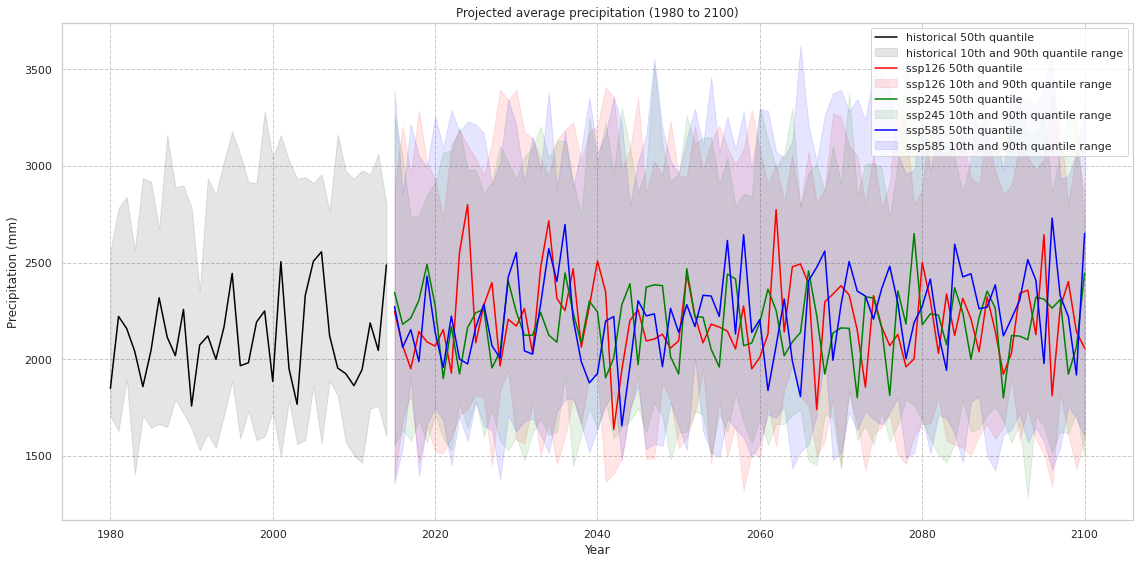

In [494]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))

colours = ['black','red','green','blue']
for i in np.arange(len(experiments)):
    ax.plot(data_50.year, data_50[i,:], color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 50th quantile')
    ax.fill_between(data_50.year, data_90[i,:], data_10[i,:], alpha=0.1, color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 10th and 90th quantile range')

#ax.set_xlim(2100)
ax.set_title('Projected average precipitation (1980 to 2100)')
ax.set_ylabel('Precipitation (mm)')
ax.set_xlabel('Year')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')


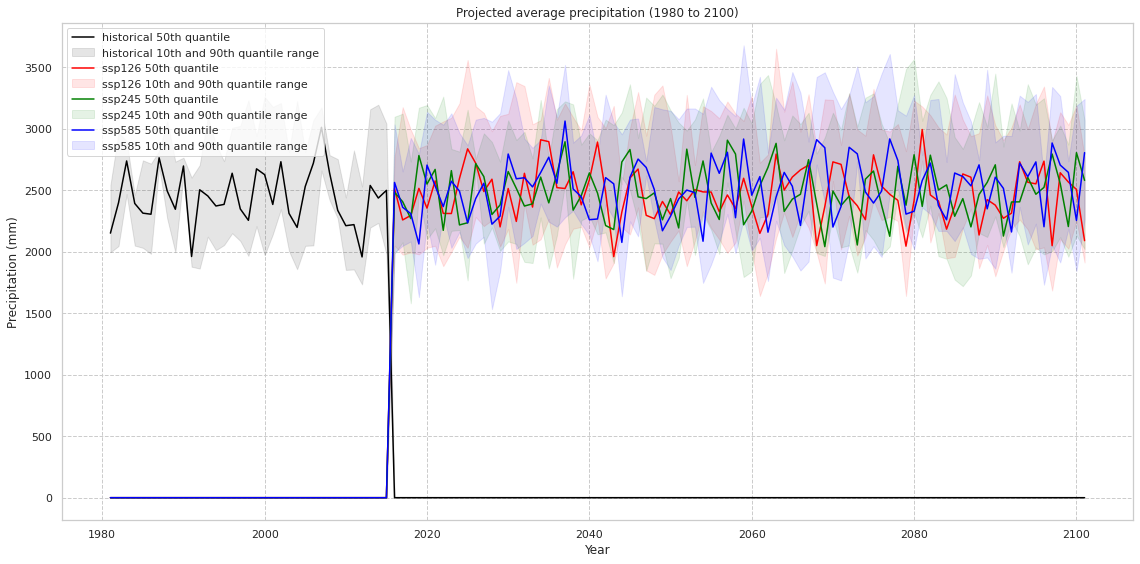

In [490]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))

colours = ['black','red','green','blue']
for i in np.arange(len(experiments)):
    ax.plot(data_50.time, data_50[i,:], color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 50th quantile')
    ax.fill_between(data_50.time, data_90[i,:], data_10[i,:], alpha=0.1, color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 10th and 90th quantile range')

#ax.set_xlim(2100)
ax.set_title('Projected average precipitation (1980 to 2100)')
ax.set_ylabel('Precipitation (mm)')
ax.set_xlabel('Year')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

#fig.savefig(f'{DATADIR}CMIP6_annual_global_tas.png')

# Monthly Timeseries

### Monthly precip

/tmp/ipykernel_3749/3751587075.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(('Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'), fontsize=16)


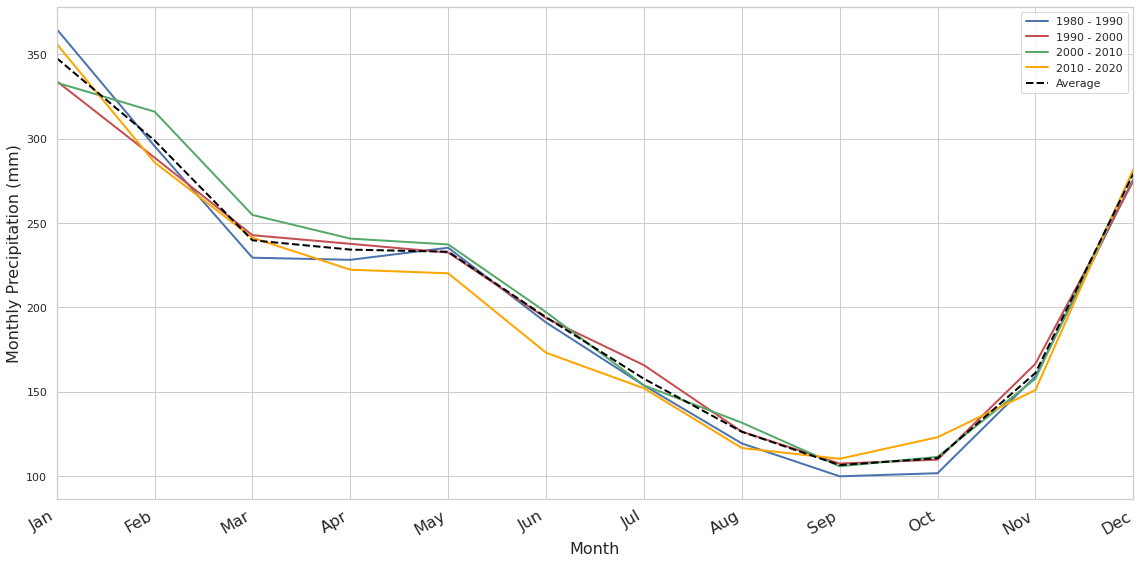

In [154]:
precip = monthly_precip.pr.mean(dim='model')

fig, ax = plt.subplots(1, 1 , figsize=(16,8))

precip[0].sel(time=slice("1980", "1990")).groupby('time.month').mean().plot(ax=ax, color='b', linewidth=2, label='1980 - 1990')
precip[0].sel(time=slice("1990", "2000")).groupby('time.month').mean().plot(ax=ax,  color='r', linewidth=2, label='1990 - 2000')
precip[0].sel(time=slice("2000", "2010")).groupby('time.month').mean().plot(ax=ax,  color='g', linewidth=2, label='2000 - 2010')
precip[0].sel(time=slice("2010", "2020")).groupby('time.month').mean().plot(ax=ax,  color='orange', linewidth=2, label='2010 - 2020')
precip[0].groupby('time.month').mean().plot(ax=ax,  color='black', linewidth=2, linestyle= 'dashed', label='Average')

ax.legend()
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Monthly Precipitation (mm)', fontsize=16)

fig.autofmt_xdate()


plt.title('')
plt.xlim(1, 12)
plt.locator_params(axis='x', nbins=12)
ax.set_xticklabels(('Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'), fontsize=16)
plt.tight_layout()

#plt.savefig('MonthlyPrecip.png', dpi=300)

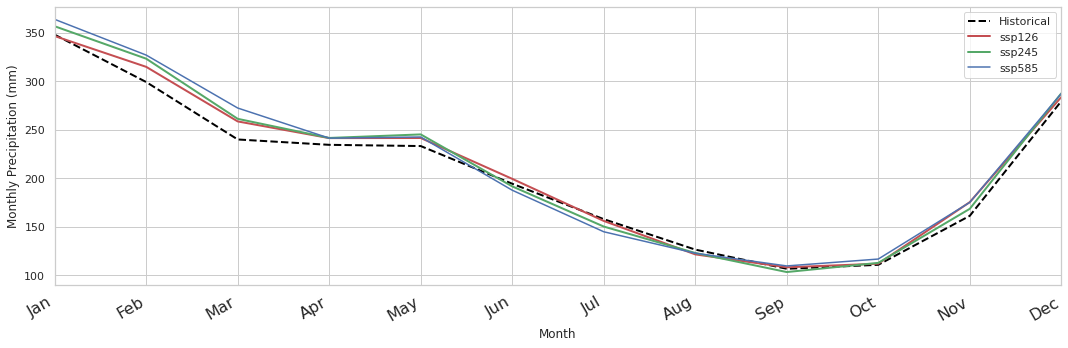

In [155]:
precip = monthly_precip.pr.mean(dim='model')
precip = precip.groupby('time.month').mean()

fig, ax = plt.subplots(1, 1 , figsize=(15,5))

ax.plot(precip[0],  color='black', linewidth=2, linestyle= 'dashed',label='Historical')
ax.plot(precip[1],  color='r', linewidth=2, label='ssp126')
ax.plot(precip[2],  color='g', linewidth=2, label='ssp245')
ax.plot(precip[3], color='b', label='ssp585')

ax.legend()
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Monthly Precipitation (mm)', fontsize=12)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
plt.xlim(0, 11)

#plt.locator_params(axis='x', nbins=12)

positions = [0, 1, 2, 3, 4, 5,6,7,8,9,10,11]

ax.xaxis.set_major_locator(ticker.FixedLocator(positions))

ax.set_xticklabels(('Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'), fontsize=16)

plt.tight_layout()

# Yearly precipitation anomalies from Yearly CMIP CDS 

### Historical

**Monthly data**

In [109]:
precip = monthly_precip.pr.mean(dim='model')
# Mean
precip_clim = precip[0].groupby('time.month').mean('time')
# Difference
ann_pr_anom = precip[0].groupby('time.month') - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc['1980':'2015']

df_pr = ann_pr_anom.to_dataframe()
df_pr = df_pr.resample('1Y').sum()

df_pr['positive'] = df_pr['pr'] > 0
df_pr['Rolling'] = df_pr['pr'].rolling(5).mean()
df_pr.reset_index(inplace=True)

df_pr['positive'] = df_pr['positive'].astype(str)

df_pr['positive'] = df_pr['positive'].str.replace('True','Positive')
df_pr['positive'] = df_pr['positive'].str.replace('False','Negative')

df_pr['time'] = df_pr['time'].dt.year

df_pr.rename(columns={'positive':'Anomaly', 'time':'year'}, inplace=True)

#df.reset_index(inplace=True)
bar = alt.Chart(df_pr).mark_bar().encode(
    x="year:O",
    y="pr:Q",
    color='Anomaly:N'
).properties(width=600).encode(x=alt.X('year:O', axis=alt.Axis(title='Year',titleFontSize=15, labelFontSize=12)),
                              y=alt.Y('pr:Q', axis=alt.Axis( title='Annual Precipitation Anomaly (mm)',titleFontSize=15, labelFontSize=12)))
line = alt.Chart(df_pr).mark_line(color='red').transform_window(
    # The field to average
    rolling_mean='mean(pr)',
    # The number of values before and after the current value to include.
    frame=[-9, 0]
).encode(
    x='year:O',
    y='rolling_mean:Q'
)


(bar + line).properties(width=600)

/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 121 times more chunks
  return self.array[key]


alt.LayerChart(...)

**Annual data**

In [111]:
precip = annual_precip.pr.mean(dim='model')
# Mean
precip_clim = precip[0].dropna(dim='year').mean()
# Difference
ann_pr_anom = precip[0].dropna(dim='year') - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc['1980':'2015']

df_pr = ann_pr_anom.to_dataframe()
df_pr['positive'] = df_pr['pr'] > 0
df_pr['Rolling'] = df_pr['pr'].rolling(5).mean()
df_pr.reset_index(inplace=True)
df_pr.head() # show only first five rows

df_pr['positive'] = df_pr['positive'].astype(str)

df_pr['positive'] = df_pr['positive'].str.replace('True','Positive')
df_pr['positive'] = df_pr['positive'].str.replace('False','Negative')

df_pr.rename(columns={'positive':'Anomaly'}, inplace=True)

#df.reset_index(inplace=True)
bar = alt.Chart(df_pr).mark_bar().encode(
    x="year:O",
    y="pr:Q",
    color='Anomaly:N'
).properties(width=600).encode(x=alt.X('year:O', axis=alt.Axis(title='Year',titleFontSize=15, labelFontSize=12)),
                              y=alt.Y('pr:Q', axis=alt.Axis( title='Annual Precipitation Anomaly (mm)',titleFontSize=15, labelFontSize=12)))
line = alt.Chart(df_pr).mark_line(color='red').transform_window(
    # The field to average
    rolling_mean='mean(pr)',
    # The number of values before and after the current value to include.
    frame=[-9, 0]
).encode(
    x='year:O',
    y='rolling_mean:Q'
)


(bar + line).properties(width=600, title='Historical')

alt.LayerChart(...)

### SSP126

**Monthly data**

In [112]:
precip = monthly_precip.pr.mean(dim='model')
# Mean
precip_clim = precip[0].groupby('time.month').mean('time')
# Difference
ann_pr_anom = precip[1].groupby('time.month') - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc['2015':]

df_pr = ann_pr_anom.to_dataframe()
df_pr = df_pr.resample('1Y').sum()

df_pr['positive'] = df_pr['pr'] > 0
df_pr['Rolling'] = df_pr['pr'].rolling(5).mean()
df_pr.reset_index(inplace=True)

df_pr['positive'] = df_pr['positive'].astype(str)

df_pr['positive'] = df_pr['positive'].str.replace('True','Positive')
df_pr['positive'] = df_pr['positive'].str.replace('False','Negative')

df_pr['time'] = df_pr['time'].dt.year

df_pr.rename(columns={'positive':'Anomaly', 'time':'year'}, inplace=True)

#df.reset_index(inplace=True)
bar = alt.Chart(df_pr).mark_bar().encode(
    x="year:O",
    y="pr:Q",
    color='Anomaly:N'
).properties(width=600).encode(x=alt.X('year:O', axis=alt.Axis(title='Year',titleFontSize=15, labelFontSize=12)),
                              y=alt.Y('pr:Q', axis=alt.Axis( title='Annual Precipitation Anomaly (mm)',titleFontSize=15, labelFontSize=12)))
line = alt.Chart(df_pr).mark_line(color='red').transform_window(
    # The field to average
    rolling_mean='mean(pr)',
    # The number of values before and after the current value to include.
    frame=[-9, 0]
).encode(
    x='year:O',
    y='rolling_mean:Q'
)


(bar + line).properties(width=600)

/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 121 times more chunks
  return self.array[key]


alt.LayerChart(...)

**Annual Data**

In [160]:
precip = annual_precip.pr.mean(dim='model')
# Select Historical
precip_clim = precip[0].dropna(dim='year').mean()
# Difference
ann_pr_anom = precip[1].dropna(dim='year') - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc['2015':'2100']

df_pr = ann_pr_anom.to_dataframe()
df_pr['positive'] = df_pr['pr'] > 0
df_pr['Rolling'] = df_pr['pr'].rolling(5).mean()
df_pr.reset_index(inplace=True)
df_pr.head() # show only first five rows

df_pr['positive'] = df_pr['positive'].astype(str)

df_pr['positive'] = df_pr['positive'].str.replace('True','Positive')
df_pr['positive'] = df_pr['positive'].str.replace('False','Negative')

df_pr.rename(columns={'positive':'Anomaly'}, inplace=True)

#df.reset_index(inplace=True)
bar = alt.Chart(df_pr).mark_bar().encode(
    x="year:O",
    y="pr:Q",
    color='Anomaly:N'
).properties(width=1000).encode(x=alt.X('year:O', axis=alt.Axis(title='Year',titleFontSize=15, labelFontSize=12)),
                              y=alt.Y('pr:Q', axis=alt.Axis( title='Annual Precipitation Anomaly (mm)',titleFontSize=15, labelFontSize=12)))
line = alt.Chart(df_pr).mark_line(color='red').transform_window(
    # The field to average
    rolling_mean='mean(pr)',
    # The number of values before and after the current value to include.
    frame=[-9, 0]
).encode(
    x='year:O',
    y='rolling_mean:Q'
)


(bar + line).properties(width=1000, title='SSP126')

alt.LayerChart(...)

### SSP245

In [162]:
precip = annual_precip.pr.mean(dim='model')
# Select Historical
precip_clim = precip[0].dropna(dim='year').mean()
# Difference
ann_pr_anom = precip[2].dropna(dim='year') - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc['2015':'2100']

df_pr = ann_pr_anom.to_dataframe()
df_pr['positive'] = df_pr['pr'] > 0
df_pr['Rolling'] = df_pr['pr'].rolling(5).mean()
df_pr.reset_index(inplace=True)
df_pr.head() # show only first five rows

df_pr['positive'] = df_pr['positive'].astype(str)

df_pr['positive'] = df_pr['positive'].str.replace('True','Positive')
df_pr['positive'] = df_pr['positive'].str.replace('False','Negative')

df_pr.rename(columns={'positive':'Anomaly'}, inplace=True)

#df.reset_index(inplace=True)
bar = alt.Chart(df_pr).mark_bar().encode(
    x="year:O",
    y="pr:Q",
    color='Anomaly:N'
).properties(width=1000).encode(x=alt.X('year:O', axis=alt.Axis(title='Year',titleFontSize=15, labelFontSize=12)),
                              y=alt.Y('pr:Q', axis=alt.Axis( title='Annual Precipitation Anomaly (mm)',titleFontSize=15, labelFontSize=12)))
line = alt.Chart(df_pr).mark_line(color='red').transform_window(
    # The field to average
    rolling_mean='mean(pr)',
    # The number of values before and after the current value to include.
    frame=[-9, 0]
).encode(
    x='year:O',
    y='rolling_mean:Q'
)


(bar + line).properties(width=1000, title='SSP245')

alt.LayerChart(...)

### SSP585

In [163]:
precip = annual_precip.pr.mean(dim='model')
# Select Historical
precip_clim = precip[0].dropna(dim='year').mean()
# Difference
ann_pr_anom = precip[3].dropna(dim='year') - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc['2015':'2100']

df_pr = ann_pr_anom.to_dataframe()
df_pr['positive'] = df_pr['pr'] > 0
df_pr['Rolling'] = df_pr['pr'].rolling(5).mean()
df_pr.reset_index(inplace=True)
df_pr.head() # show only first five rows

df_pr['positive'] = df_pr['positive'].astype(str)

df_pr['positive'] = df_pr['positive'].str.replace('True','Positive')
df_pr['positive'] = df_pr['positive'].str.replace('False','Negative')

df_pr.rename(columns={'positive':'Anomaly'}, inplace=True)

#df.reset_index(inplace=True)
bar = alt.Chart(df_pr).mark_bar().encode(
    x="year:O",
    y="pr:Q",
    color='Anomaly:N'
).properties(width=1000).encode(x=alt.X('year:O', axis=alt.Axis(title='Year',titleFontSize=15, labelFontSize=12)),
                              y=alt.Y('pr:Q', axis=alt.Axis( title='Annual Precipitation Anomaly (mm)',titleFontSize=15, labelFontSize=12)))
line = alt.Chart(df_pr).mark_line(color='red').transform_window(
    # The field to average
    rolling_mean='mean(pr)',
    # The number of values before and after the current value to include.
    frame=[-9, 0]
).encode(
    x='year:O',
    y='rolling_mean:Q'
)


(bar + line).properties(width=1000, title='SSP585')

alt.LayerChart(...)

# Annual Percentiles with Yearly CMIP6 CDS

### Historical

**Monthly Data**

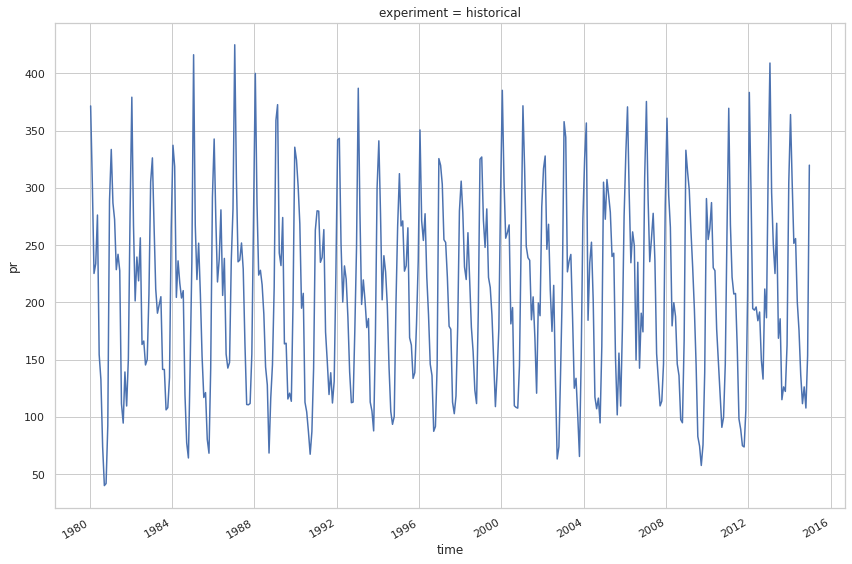

In [145]:
precip = monthly_precip.pr.mean(dim='model')
# Select Historical
precip[0].plot()

/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 121 times more chunks
  return self.array[key]


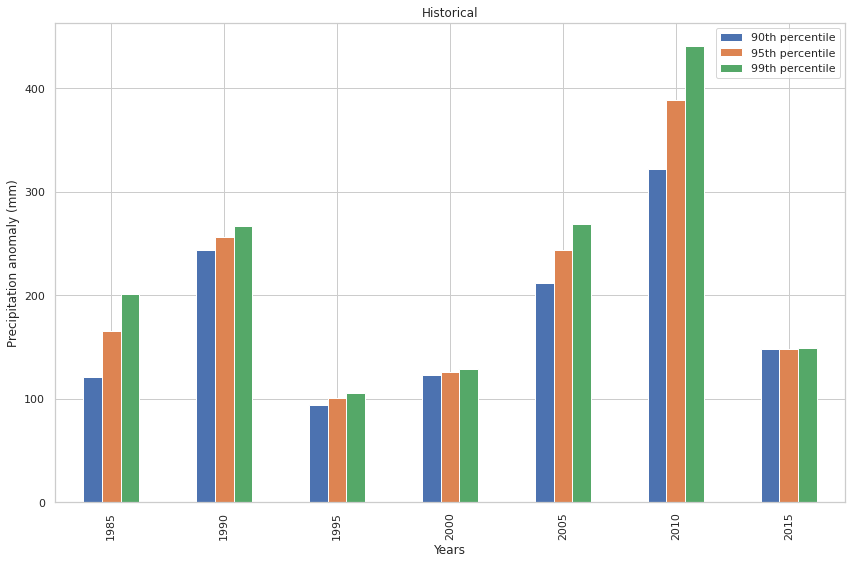

In [149]:
precip = monthly_precip.pr.mean(dim='model')
# Select Historical
precip_clim = precip[0].groupby('time.month').mean('time')
# Difference
ann_pr_anom = precip[0].groupby('time.month') - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc[:'2015']

df_pr = ann_pr_anom.to_dataframe()

df_pr = df_pr.resample('1Y').sum()

df_pr['positive'] = df_pr['pr'] > 0
df_pr['Rolling'] = df_pr['pr'].rolling(5).mean()


df_pr.reset_index(inplace=True)

df_pr['positive'] = df_pr['positive'].astype(str)

df_pr['positive'] = df_pr['positive'].str.replace('True','Positive')
df_pr['positive'] = df_pr['positive'].str.replace('False','Negative')

df_pr['time'] = df_pr['time'].dt.year

df_pr.rename(columns={'positive':'Anomaly', 'time':'year'}, inplace=True)


df_pr.year = pd.to_datetime(df_pr.year, format='%Y')

anom_hist_quant = pd.DataFrame()
anom_hist_quant['90th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.90)
anom_hist_quant['95th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.95)
anom_hist_quant['99th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.99)
anom_hist_quant = anom_hist_quant['1985':]

anom_hist_quant.index = anom_hist_quant.index.year

fig, ax = plt.subplots()

anom_hist_quant.plot(kind='bar', ax=ax, title='Historical')

#labels = ['90th percentile','95th percentile','99th percentile']


#ax.legend(labels)
plt.xlabel('Years')
plt.ylabel('Precipitation anomaly (mm)')
plt.tight_layout()

**Annual Data**

In [119]:
precip = annual_precip.pr.mean(dim='model')
# Select Historical
precip_clim = precip[0].dropna(dim='year').mean()
# Difference
ann_pr_anom = precip[0].dropna(dim='year') - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc[:'2015']

df_pr = ann_pr_anom.to_dataframe()
df_pr['positive'] = df_pr['pr'] > 0
df_pr['Rolling'] = df_pr['pr'].rolling(5).sum()
df_pr.reset_index(inplace=True)
df_pr.head() # show only first five rows

df_pr['positive'] = df_pr['positive'].astype(str)

df_pr['positive'] = df_pr['positive'].str.replace('True','Positive')
df_pr['positive'] = df_pr['positive'].str.replace('False','Negative')

df_pr.rename(columns={'positive':'Anomaly'}, inplace=True)

In [120]:
df_pr.year = pd.to_datetime(df_pr.year, format='%Y')

In [121]:
anom_hist_quant = pd.DataFrame()
anom_hist_quant['90th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.90)
anom_hist_quant['95th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.95)
anom_hist_quant['99th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.99)
anom_hist_quant = anom_hist_quant['1985':]

In [122]:
anom_hist_quant.index = anom_hist_quant.index.year

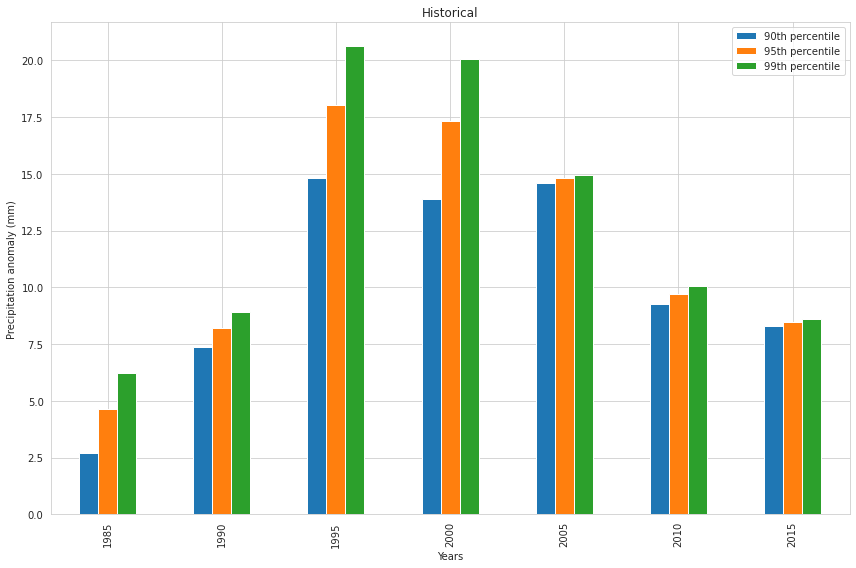

In [123]:
fig, ax = plt.subplots()

anom_hist_quant.plot(kind='bar', ax=ax, title='Historical')

#labels = ['90th percentile','95th percentile','99th percentile']


#ax.legend(labels)
plt.xlabel('Years')
plt.ylabel('Precipitation anomaly (mm)')
plt.tight_layout()

### SSP126

/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 121 times more chunks
  return self.array[key]


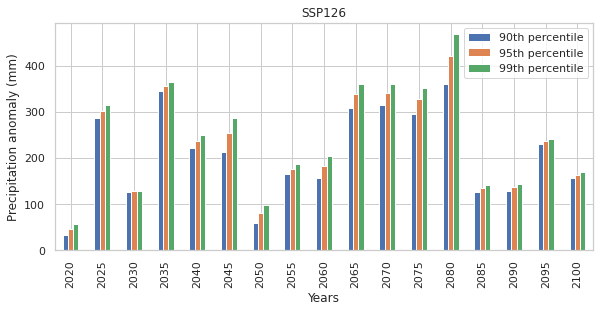

In [163]:
precip = monthly_precip.pr.mean(dim='model')
# Select Historical
precip_clim = precip[0].groupby('time.month').mean('time')
# Difference
ann_pr_anom = precip[1].groupby('time.month') - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc['2015':]

df_pr = ann_pr_anom.to_dataframe()

df_pr = df_pr.resample('1Y').sum()

df_pr['positive'] = df_pr['pr'] > 0
df_pr['Rolling'] = df_pr['pr'].rolling(5).mean()


df_pr.reset_index(inplace=True)

df_pr['positive'] = df_pr['positive'].astype(str)

df_pr['positive'] = df_pr['positive'].str.replace('True','Positive')
df_pr['positive'] = df_pr['positive'].str.replace('False','Negative')

df_pr['time'] = df_pr['time'].dt.year

df_pr.rename(columns={'positive':'Anomaly', 'time':'year'}, inplace=True)


df_pr.year = pd.to_datetime(df_pr.year, format='%Y')

anom_hist_quant = pd.DataFrame()
anom_hist_quant['90th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.90)
anom_hist_quant['95th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.95)
anom_hist_quant['99th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.99)
anom_hist_quant = anom_hist_quant['2020':]

anom_hist_quant.index = anom_hist_quant.index.year

fig, ax = plt.subplots()

anom_hist_quant.plot(kind='bar', ax=ax, title='SSP126')

#labels = ['90th percentile','95th percentile','99th percentile']


#ax.legend(labels)
plt.xlabel('Years')
plt.ylabel('Precipitation anomaly (mm)')
plt.tight_layout()

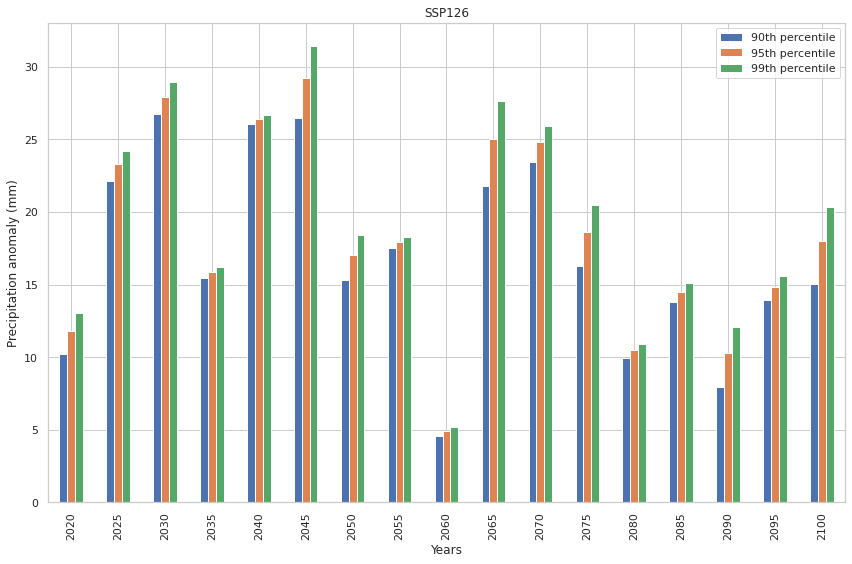

In [170]:
precip = annual_precip.pr.mean(dim='model')
# Select Historical
precip_clim = precip[0].mean()
# Difference
ann_pr_anom = precip[1] - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc['2015':]

df_pr = ann_pr_anom.to_dataframe()
df_pr['positive'] = df_pr['pr'] > 0
df_pr['Rolling'] = df_pr['pr'].rolling(5).mean()
df_pr.reset_index(inplace=True)
df_pr.head() # show only first five rows

df_pr['positive'] = df_pr['positive'].astype(str)

df_pr['positive'] = df_pr['positive'].str.replace('True','Positive')
df_pr['positive'] = df_pr['positive'].str.replace('False','Negative')

df_pr.rename(columns={'positive':'Anomaly'}, inplace=True)

df_pr.year = pd.to_datetime(df_pr.year, format='%Y')

anom_hist_quant = pd.DataFrame()
anom_hist_quant['90th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.90)
anom_hist_quant['95th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.95)
anom_hist_quant['99th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.99)
anom_hist_quant = anom_hist_quant['2020':]

anom_hist_quant.index = anom_hist_quant.index.year

fig, ax = plt.subplots()

anom_hist_quant.plot(kind='bar', ax=ax, title='SSP126')

#labels = ['90th percentile','95th percentile','99th percentile']


#ax.legend(labels)
plt.xlabel('Years')
plt.ylabel('Precipitation anomaly (mm)')
plt.tight_layout()

## SSP245

/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 121 times more chunks
  return self.array[key]


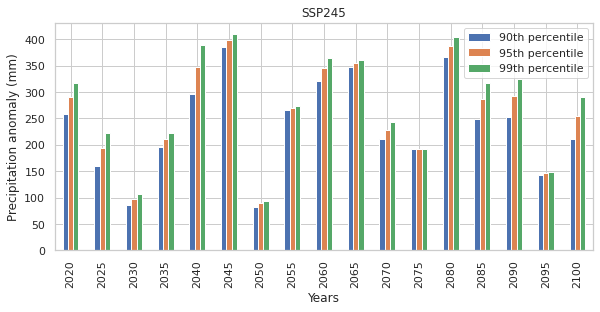

In [164]:
precip = monthly_precip.pr.mean(dim='model')
# Select Historical
precip_clim = precip[0].groupby('time.month').mean('time')
# Difference
ann_pr_anom = precip[2].groupby('time.month') - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc['2015':]

df_pr = ann_pr_anom.to_dataframe()

df_pr = df_pr.resample('1Y').sum()

df_pr['positive'] = df_pr['pr'] > 0
df_pr['Rolling'] = df_pr['pr'].rolling(5).mean()


df_pr.reset_index(inplace=True)

df_pr['positive'] = df_pr['positive'].astype(str)

df_pr['positive'] = df_pr['positive'].str.replace('True','Positive')
df_pr['positive'] = df_pr['positive'].str.replace('False','Negative')

df_pr['time'] = df_pr['time'].dt.year

df_pr.rename(columns={'positive':'Anomaly', 'time':'year'}, inplace=True)


df_pr.year = pd.to_datetime(df_pr.year, format='%Y')

anom_hist_quant = pd.DataFrame()
anom_hist_quant['90th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.90)
anom_hist_quant['95th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.95)
anom_hist_quant['99th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.99)
anom_hist_quant = anom_hist_quant['2020':]

anom_hist_quant.index = anom_hist_quant.index.year

fig, ax = plt.subplots()

anom_hist_quant.plot(kind='bar', ax=ax, title='SSP245')

#labels = ['90th percentile','95th percentile','99th percentile']


#ax.legend(labels)
plt.xlabel('Years')
plt.ylabel('Precipitation anomaly (mm)')
plt.tight_layout()

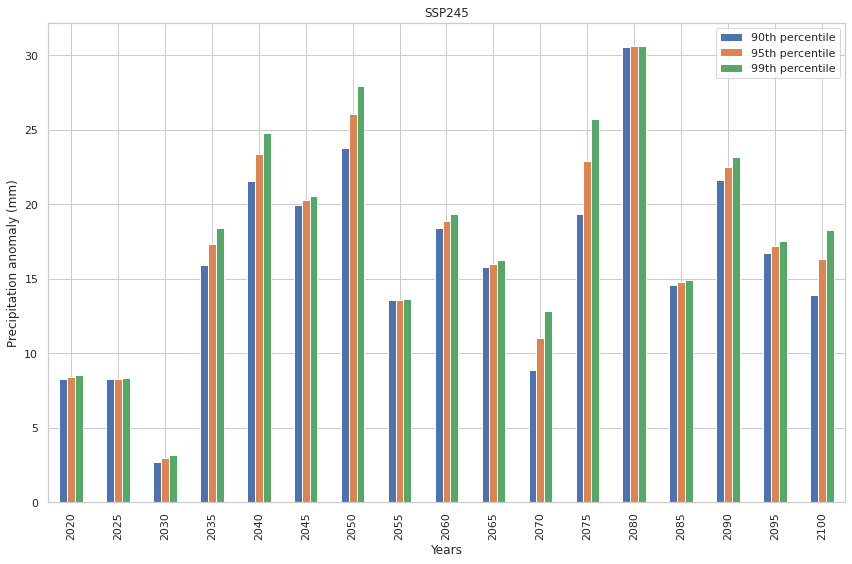

In [171]:
precip = annual_precip.pr.mean(dim='model')
# Select Historical
precip_clim = precip[0].mean()
# Difference
ann_pr_anom = precip[2] - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc['2015':]

df_pr = ann_pr_anom.to_dataframe()
df_pr['positive'] = df_pr['pr'] > 0
df_pr['Rolling'] = df_pr['pr'].rolling(5).mean()
df_pr.reset_index(inplace=True)
df_pr.head() # show only first five rows

df_pr['positive'] = df_pr['positive'].astype(str)

df_pr['positive'] = df_pr['positive'].str.replace('True','Positive')
df_pr['positive'] = df_pr['positive'].str.replace('False','Negative')

df_pr.rename(columns={'positive':'Anomaly'}, inplace=True)

df_pr.year = pd.to_datetime(df_pr.year, format='%Y')

anom_hist_quant = pd.DataFrame()
anom_hist_quant['90th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.90)
anom_hist_quant['95th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.95)
anom_hist_quant['99th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.99)
anom_hist_quant = anom_hist_quant['2020':]

anom_hist_quant.index = anom_hist_quant.index.year

fig, ax = plt.subplots()

anom_hist_quant.plot(kind='bar', ax=ax, title='SSP245')

#labels = ['90th percentile','95th percentile','99th percentile']


#ax.legend(labels)
plt.xlabel('Years')
plt.ylabel('Precipitation anomaly (mm)')
plt.tight_layout()

### SSP585

/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 121 times more chunks
  return self.array[key]


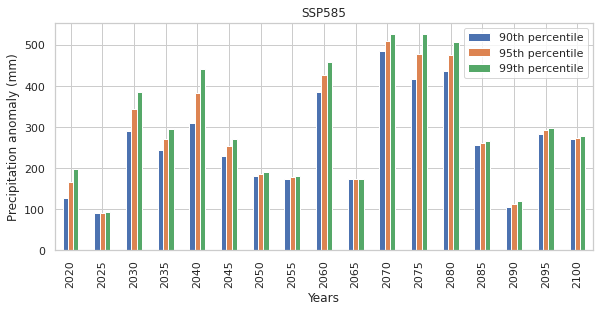

In [165]:
precip = monthly_precip.pr.mean(dim='model')
# Select Historical
precip_clim = precip[0].groupby('time.month').mean('time')
# Difference
ann_pr_anom = precip[3].groupby('time.month') - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc['2015':]

df_pr = ann_pr_anom.to_dataframe()

df_pr = df_pr.resample('1Y').sum()

df_pr['positive'] = df_pr['pr'] > 0
df_pr['Rolling'] = df_pr['pr'].rolling(5).mean()


df_pr.reset_index(inplace=True)

df_pr['positive'] = df_pr['positive'].astype(str)

df_pr['positive'] = df_pr['positive'].str.replace('True','Positive')
df_pr['positive'] = df_pr['positive'].str.replace('False','Negative')

df_pr['time'] = df_pr['time'].dt.year

df_pr.rename(columns={'positive':'Anomaly', 'time':'year'}, inplace=True)


df_pr.year = pd.to_datetime(df_pr.year, format='%Y')

anom_hist_quant = pd.DataFrame()
anom_hist_quant['90th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.90)
anom_hist_quant['95th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.95)
anom_hist_quant['99th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.99)
anom_hist_quant = anom_hist_quant['2020':]

anom_hist_quant.index = anom_hist_quant.index.year

fig, ax = plt.subplots()

anom_hist_quant.plot(kind='bar', ax=ax, title='SSP585')

#labels = ['90th percentile','95th percentile','99th percentile']


#ax.legend(labels)
plt.xlabel('Years')
plt.ylabel('Precipitation anomaly (mm)')
plt.tight_layout()

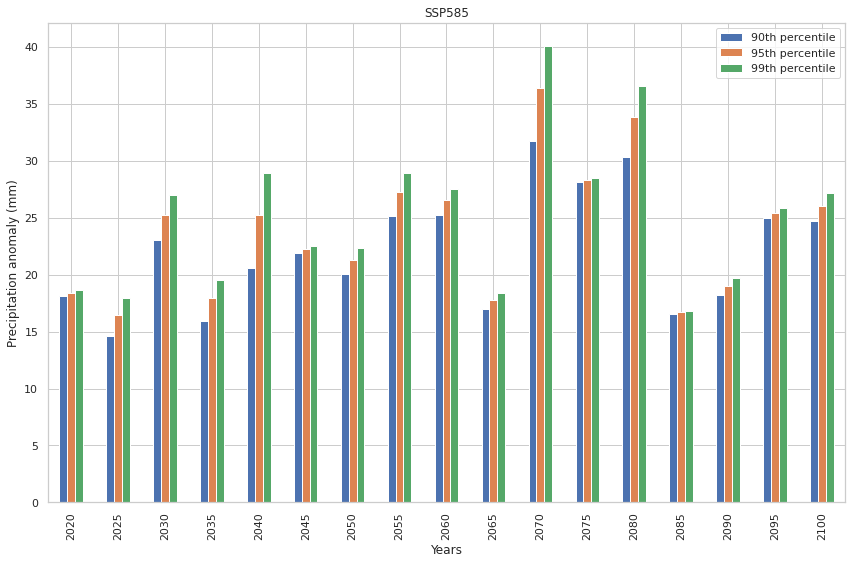

In [172]:
precip = annual_precip.pr.mean(dim='model')
# Select Historical
precip_clim = precip[0].mean()
# Difference
ann_pr_anom = precip[3] - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc['2015':]

df_pr = ann_pr_anom.to_dataframe()
df_pr['positive'] = df_pr['pr'] > 0
df_pr['Rolling'] = df_pr['pr'].rolling(5).mean()
df_pr.reset_index(inplace=True)
df_pr.head() # show only first five rows

df_pr['positive'] = df_pr['positive'].astype(str)

df_pr['positive'] = df_pr['positive'].str.replace('True','Positive')
df_pr['positive'] = df_pr['positive'].str.replace('False','Negative')

df_pr.rename(columns={'positive':'Anomaly'}, inplace=True)

df_pr.year = pd.to_datetime(df_pr.year, format='%Y')

anom_hist_quant = pd.DataFrame()
anom_hist_quant['90th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.90)
anom_hist_quant['95th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.95)
anom_hist_quant['99th percentile'] = df_pr.groupby(pd.Grouper(key='year', freq='5Y')).pr.quantile(0.99)
anom_hist_quant = anom_hist_quant['2020':]

anom_hist_quant.index = anom_hist_quant.index.year

fig, ax = plt.subplots()

anom_hist_quant.plot(kind='bar', ax=ax, title='SSP585')

#labels = ['90th percentile','95th percentile','99th percentile']


#ax.legend(labels)
plt.xlabel('Years')
plt.ylabel('Precipitation anomaly (mm)')
plt.tight_layout()

# Monthly precipitation Monthly CMIP6 CDS

In [168]:
precip = monthly_precip.pr.mean(dim='model')
# Select Historical
precip_clim = precip[0].groupby('time.month').mean('time')
# Mean
month_anom = precip[0].groupby('time.month') - precip_clim

m_precip = month_anom.to_dataframe()

m_precip.reset_index(inplace=True)

m_precip['time'] = pd.to_datetime(m_precip['time'])

m_precip['year'] = m_precip['time'].dt.year

m_precip['month'] = m_precip['time'].dt.month_name()

m_precip = m_precip[['pr','year','month']]

m_precip_anom = m_precip.pivot_table(columns='year',index='month',values='pr')

m_precip_anom = m_precip_anom[[1980,1985,1990,
            1995,2000,2005,2010]]

m_precip_anom = m_precip_anom.reindex(([ 'January','February','March','April', 'May','June','July','August' ,'September','October', 'November','December']))

/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 121 times more chunks
  return self.array[key]


Text(0.5, 0, 'Month')

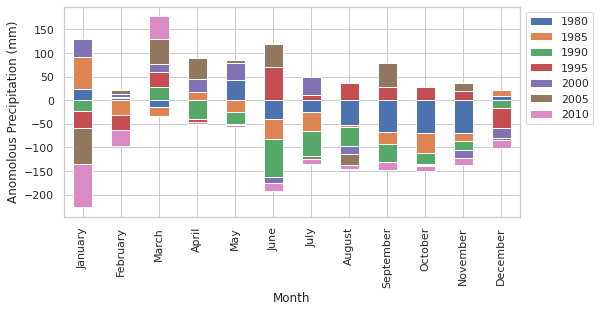

In [169]:
#set seaborn plotting aesthetics
plt.rcParams["figure.figsize"] = [8.5, 4.50]
plt.rcParams["figure.autolayout"] = True
sns.set(style='whitegrid')

#create stacked bar chart
m_precip_anom.plot(kind='bar', stacked=True)

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.ylabel('Anomolous Precipitation (mm)')
plt.xlabel('Month')

### Decade trend anomaly

#### Historical

In [282]:
precip = monthly_precip.pr.mean(dim='model')
# Select Historical
precip_clim = precip[0].groupby('time.month').mean('time')
# Difference
ann_pr_anom = precip[0].groupby('time.month') - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc[:'2010']

df_pr = ann_pr_anom.to_dataframe()

df_pr = df_pr.resample('1Y').sum()

df_pr = ann_pr_anom.to_dataframe()

df_pr.reset_index(inplace=True)

df_pr['year'] = pd.to_datetime(df_pr.time.dt.year, format='%Y')

hist_anom = df_pr[['experiment','year','pr']]


mean_hist_anom = hist_anom.groupby(pd.Grouper(key='year', freq='10Y')).sum()

mean_hist_anom.index = mean_hist_anom.index.year

mean_hist_anom.rename(columns={'pr':'historical'}, inplace=True)

/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 121 times more chunks
  return self.array[key]


In [283]:
mean_hist_anom

,historical
year,
1980,-254.275312
1990,-130.786957
2000,227.965002
2010,250.564613


#### SSP126

In [284]:
precip = monthly_precip.pr.mean(dim='model')
# Select Historical
precip_clim = precip[0].groupby('time.month').mean('time')
# Difference
ann_pr_anom = precip[1].groupby('time.month') - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc['2010':]

df_pr = ann_pr_anom.to_dataframe()

df_pr = df_pr.resample('1Y').sum()

df_pr = ann_pr_anom.to_dataframe()

df_pr.reset_index(inplace=True)

df_pr['year'] = pd.to_datetime(df_pr.time.dt.year, format='%Y')

ssp126_anom = df_pr[['year','pr']]

mean_ssp126_anom = ssp126_anom.groupby(pd.Grouper(key='year', freq='10Y')).sum()

mean_ssp126_anom.index = mean_ssp126_anom.index.year

mean_ssp126_anom.rename(columns={'pr':'ssp126'}, inplace=True)

/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 121 times more chunks
  return self.array[key]


#### SSP245

In [285]:
precip = monthly_precip.pr.mean(dim='model')
# Select Historical
precip_clim = precip[0].groupby('time.month').mean('time')
# Difference
ann_pr_anom = precip[2].groupby('time.month') - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc['2010':]

df_pr = ann_pr_anom.to_dataframe()

df_pr = df_pr.resample('1Y').sum()

df_pr = ann_pr_anom.to_dataframe()

df_pr.reset_index(inplace=True)

df_pr['year'] = pd.to_datetime(df_pr.time.dt.year, format='%Y')

ssp245_anom = df_pr[['year','pr']]

mean_ssp245_anom = ssp245_anom.groupby(pd.Grouper(key='year', freq='10Y')).sum()

mean_ssp245_anom.index = mean_ssp245_anom.index.year

mean_ssp245_anom.rename(columns={'pr':'ssp245'}, inplace=True)

/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 121 times more chunks
  return self.array[key]


#### SSP585

In [286]:
precip = monthly_precip.pr.mean(dim='model')
# Select Historical
precip_clim = precip[0].groupby('time.month').mean('time')
# Difference
ann_pr_anom = precip[3].groupby('time.month') - precip_clim
# Filter range
ann_pr_anom = ann_pr_anom.loc['2010':]

df_pr = ann_pr_anom.to_dataframe()

df_pr = df_pr.resample('1Y').sum()

df_pr = ann_pr_anom.to_dataframe()

df_pr.reset_index(inplace=True)

df_pr['year'] = pd.to_datetime(df_pr.time.dt.year, format='%Y')


ssp585_anom = df_pr[['year','pr']]

mean_ssp585_anom = ssp585_anom.groupby(pd.Grouper(key='year', freq='10Y')).sum()

mean_ssp585_anom.index = mean_ssp585_anom.index.year

mean_ssp585_anom.rename(columns={'pr':'ssp585'}, inplace=True)

/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 121 times more chunks
  return self.array[key]


In [287]:
decade_trend_precip = pd.concat([mean_hist_anom,mean_ssp126_anom,mean_ssp245_anom,mean_ssp585_anom], axis=1)
decade_trend_precip = decade_trend_precip[1:]

#### Plot

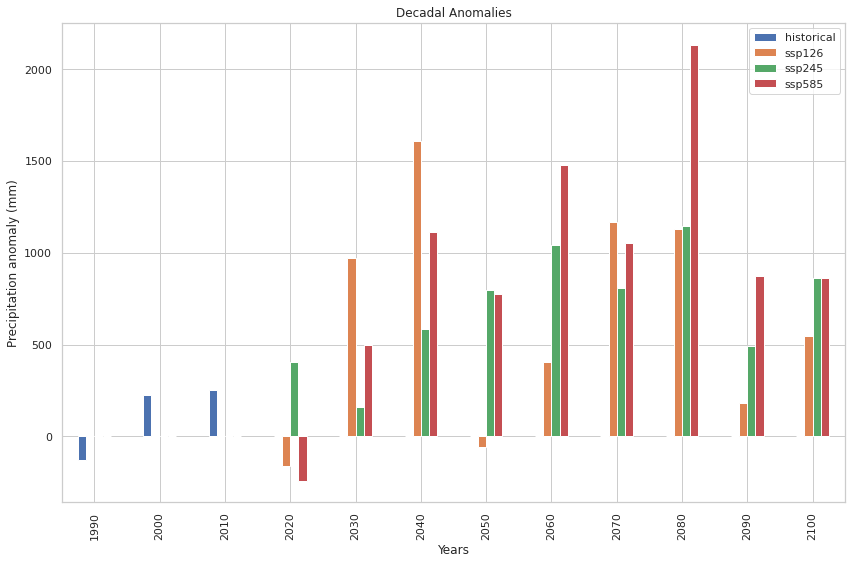

In [288]:
plt.rcParams["figure.figsize"] = [12, 8]
fig, ax = plt.subplots(1,1)

decade_trend_precip.plot(kind='bar', ax=ax)


#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


#labels = ['90th percentile','95th percentile','99th percentile']

plt.legend()
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Years')
plt.ylabel('Precipitation anomaly (mm)')
plt.title('Decadal Anomalies')
plt.tight_layout()

### Decade trend grouped

In [303]:
decade_trend_precip

,historical,ssp126,ssp245,ssp585
year,,,,
1990,-130.786957,NaN,NaN,NaN
2000,227.965002,NaN,NaN,NaN
2010,250.564613,0.000000,0.000000,0.000000
2020,NaN,-163.462945,403.018765,-239.802555
2030,NaN,972.478883,157.829595,498.646168
2040,NaN,1609.044868,583.837869,1112.320917
2050,NaN,-59.773384,797.057779,777.678883
2060,NaN,406.543890,1043.846372,1479.514501
2070,NaN,1165.931382,808.974549,1055.088277


In [304]:
decade_stack = decade_trend_precip.transpose()

In [305]:
stack_anom = decade_stack.stack()

In [306]:
stack_anom = stack_anom.to_frame()

In [307]:
stack_anom.reset_index(inplace=True)

In [308]:
stack_anom.rename(columns={'level_0':'experiment',0:'pr'}, inplace=True)

In [309]:
stack_anom

,experiment,year,pr
0,historical,1990,-130.786957
1,historical,2000,227.965002
2,historical,2010,250.564613
3,ssp126,2010,0.000000
4,ssp126,2020,-163.462945
5,ssp126,2030,972.478883
6,ssp126,2040,1609.044868
7,ssp126,2050,-59.773384
8,ssp126,2060,406.543890
9,ssp126,2070,1165.931382


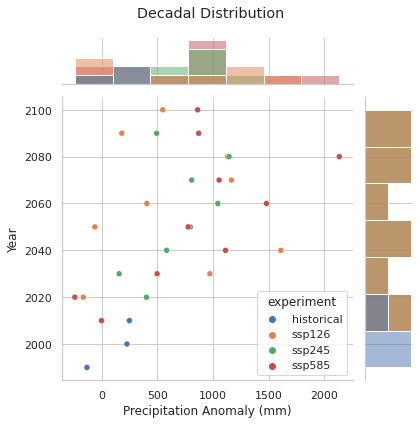

In [312]:
ax = sns.JointGrid(x = "pr", y = "year", data = stack_anom, hue='experiment')

ax.plot(sns.scatterplot, sns.histplot)

ax.set_axis_labels(xlabel='Precipitation Anomaly (mm)', ylabel='Year')

plt.suptitle('Decadal Distribution')

plt.tight_layout()

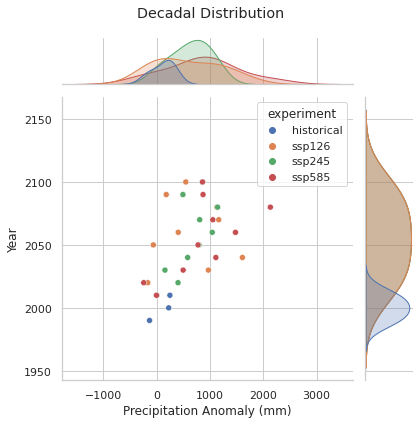

In [311]:
ax = sns.jointplot(x = "pr", y = "year", data = stack_anom, hue='experiment')
ax.set_axis_labels(xlabel='Precipitation Anomaly (mm)', ylabel='Year')
plt.suptitle('Decadal Distribution')
plt.tight_layout()

Text(0.5, 0, 'Precipitation')

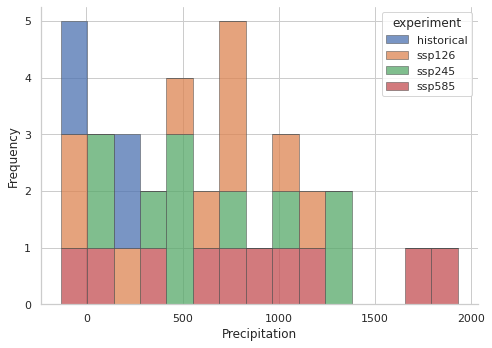

In [219]:
f, ax = plt.subplots(figsize=(7, 5))

# removes the top and right axes spines
sns.despine(f)

# plot according to classification
sns.histplot(
    stack_anom,
    x="pr", hue="experiment",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    bins=15
)

plt.ylabel('Frequency')
plt.xlabel('Precipitation')
#ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_xticks([0.5, 3.5, 5.7, 10,15,20])

### Monthly Precipitation Distribution

In [388]:
precip = monthly_precip.pr.mean(dim='model')

In [389]:
test = precip.to_dataframe()
test = test['1980':]

In [390]:
test.reset_index(inplace=True)

In [391]:
test.set_index('time', inplace=True)

In [392]:
test = test.dropna()

In [381]:
test = test.resample('1Y').sum()

In [382]:
test

,pr
time,
1980-12-31,2234.997107
1981-12-31,2475.495441
1982-12-31,2699.868748
1983-12-31,2294.311800
1984-12-31,2366.373244
...,...
2096-12-31,7520.139445
2097-12-31,7815.180335
2098-12-31,7408.534224


In [393]:
test = test.groupby('experiment').resample('1Y').sum()

In [394]:
test

pr
experiment time                   
historical 1980-12-31  2234.997107
           1981-12-31  2475.495441
           1982-12-31  2699.868748
           1983-12-31  2294.311800
           1984-12-31  2366.373244
...                            ...
ssp585     2096-12-31  2749.826823
           2097-12-31  2622.127353
           2098-12-31  2514.135126
           2099-12-31  2440.912999
           2100-12-31  2767.484711

[293 rows x 1 columns]

In [395]:
test.reset_index(inplace=True)

In [396]:
test = test.dropna(how='any')

Text(0.5, 0.98, 'Annual Mean Distribution')

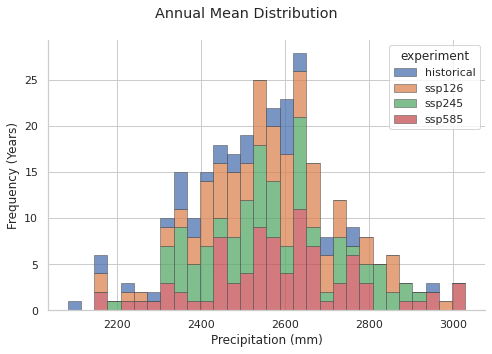

In [397]:
f, ax = plt.subplots(figsize=(7, 5))

# removes the top and right axes spines
sns.despine(f)

# plot according to classification
sns.histplot(
    test,
    x="pr", hue="experiment",
    multiple="stack",
    #palette="light",
    edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
    bins=30# log scale
)

plt.ylabel('Frequency (Years)')
plt.xlabel('Precipitation (mm)')
#ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_xticks([500, 1000, 2000, 5000, 10000])
plt.suptitle('Annual Mean Distribution')

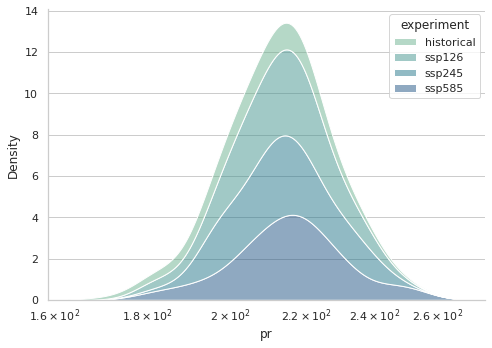

In [322]:
f, ax = plt.subplots(figsize=(7, 5))

# removes the top and right axes spines
sns.despine(f)

# plot according to classification
sns.kdeplot(
    data=test,
    x="pr", hue="experiment",multiple="stack",
    fill=True, common_norm=True,  palette="crest",
    alpha=.5, 
    log_scale=True # log scale
)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.set_xticks([500, 1000, 2000, 5000, 10000])

Text(0.5, 0.98, 'Annual Mean Distribution')

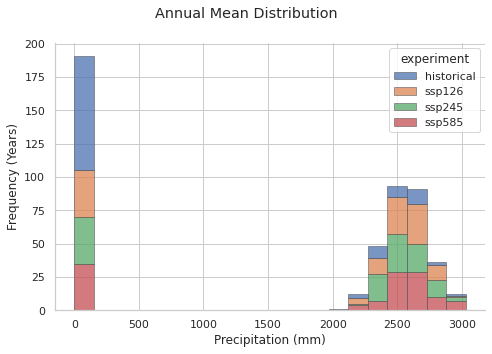

In [342]:
precip = monthly_precip.pr.mean(dim='model')

test = precip.to_dataframe()

test.reset_index(inplace=True)

test.set_index('time', inplace=True)

test = test.groupby('experiment').resample('1Y').sum()

test.reset_index(inplace=True)
f, ax = plt.subplots(figsize=(7, 5))

# removes the top and right axes spines
sns.despine(f)

# plot according to classification
sns.histplot(
    test,
    x="pr", hue="experiment",
    multiple="stack",
    #palette="light",
    edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
    bins=20# log scale
)

plt.ylabel('Frequency (Years)')
plt.xlabel('Precipitation (mm)')
#ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_xticks([500, 1000, 2000, 5000, 10000])
plt.suptitle('Annual Mean Distribution')

<AxesSubplot:ylabel='Frequency'>

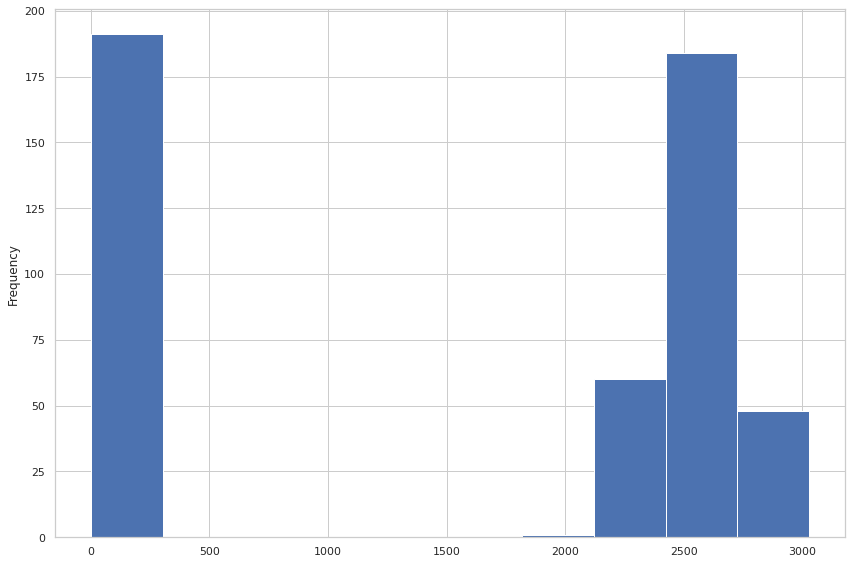

In [344]:
test.set_index('time')['pr'].plot(kind='hist')

In [333]:
test.set_index('year')['pr'].plot()

KeyError: "None of ['year'] are in the columns"

# Temperature

In [105]:
experiments = ['historical', 'ssp126', 'ssp245', 'ssp585']

models = ['hadgem3_gc31_ll', 'inm_cm5_0', 'inm_cm4_8', 'ipsl_cm6a_lr', 
          'miroc_es2l', 'mpi_esm1_2_lr', 'ukesm1_0_ll']

In [106]:
cmip6_temp_list = list()
cmip6_temp_rel = glob(f'{DATADIR}tas_Amon_*.nc')
for i in cmip6_temp_rel:
    cmip6_temp_list.append(os.path.basename(i))

In [107]:
#sorted(cmip6_temp_list)

In [108]:
ds = xr.open_dataset(f'{DATADIR}{sorted(cmip6_temp_list)[0]}')
ds

<xarray.Dataset>
Dimensions:    (time: 420, bnds: 2, lat: 144, lon: 192)
Coordinates:
  * time       (time) object 1980-01-16 00:00:00 ... 2014-12-16 00:00:00
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-06-19T12:07:37Z
    ...                     ...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/bc7c9a22-a05f-4154-9781-2b2cd934748e

In [109]:
exp = ds.attrs['experiment_id']
mod = ds.attrs['source_id']

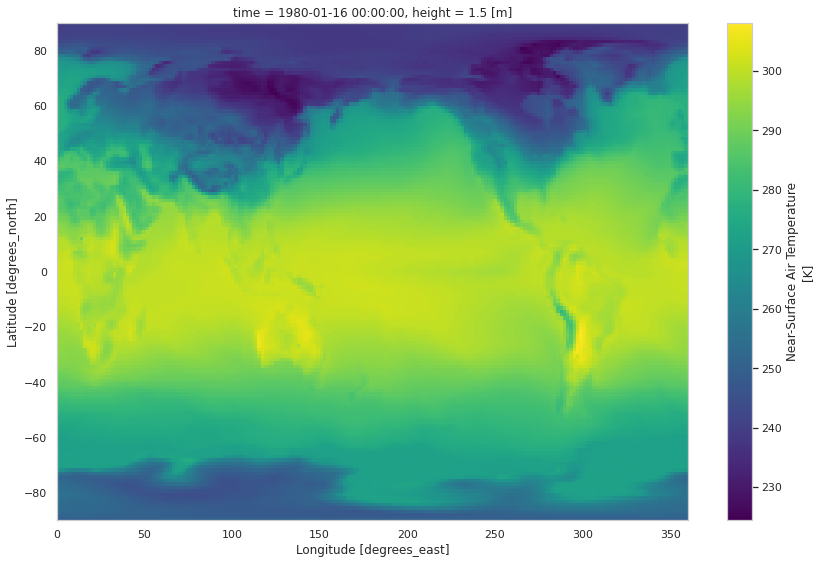

In [110]:
da = ds['tas']

da[0].plot()

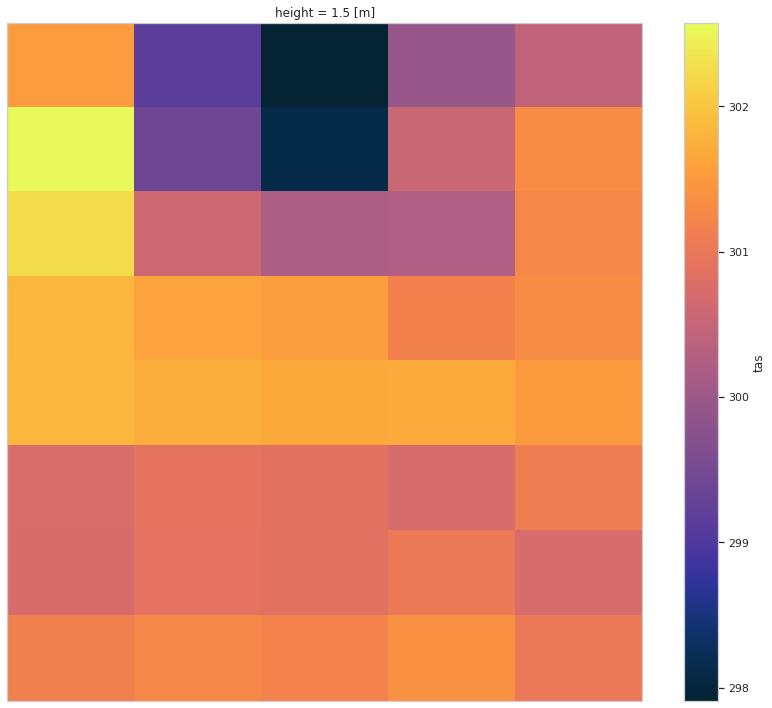

In [111]:
### Clip to region

indo = da.sel(lon = slice(117, 125), lat = slice(-11, -1))

#Let's initialise a figure. We can even set the size of the figure.
fig = plt.figure(figsize = (12, 10))

#We define our projection to be Mercator
proj = ccrs.Mercator()

#We will add the map to the figure
ax = fig.add_subplot(1, 1, 1, projection = proj)

#We calculate the climatological mean as seen in the previous step, and plot results
indo.mean('time').plot.pcolormesh(ax = ax, 
#We will use a colour map designed for temperature plots
transform = ccrs.PlateCarree(), cmap = cm.cm.thermal)

In [112]:
for i in cmip6_temp_list:
    try:
        geog_agg(i)
    except: print(f'{i} failed')

tas_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19800116-20141216_v20190624.nc failed
tas_Amon_INM-CM5-0_historical_r1i1p1f1_gr1_19800116-20141216_v20190610.nc failed
tas_Amon_INM-CM4-8_historical_r1i1p1f1_gr1_19800116-20141216_v20190530.nc failed
tas_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19800116-20141216_v20180803.nc failed
tas_Amon_MIROC-ES2L_historical_r1i1p1f2_gn_19800116-20141216_v20190823.nc failed
tas_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_19800116-20141216_v20190710.nc failed
tas_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_19800116-20141216_v20190406.nc failed
tas_Amon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_201501-204912_v20200114.nc failed
tas_Amon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_205001-210012_v20200114.nc failed
tas_Amon_INM-CM5-0_ssp126_r1i1p1f1_gr1_201501-210012_v20190619.nc failed
tas_Amon_INM-CM4-8_ssp126_r1i1p1f1_gr1_201501-210012_v20190603.nc failed
tas_Amon_IPSL-CM6A-LR_ssp126_r1i1p1f1_gr_201501-210012_v20190903.nc failed
tas_Amon_MIROC-ES2L_ssp126_r1i1p1f2_gn_201501

### Import Yearly temp from CDS

In [113]:
annual_temp = xr.open_mfdataset(f'{DATADIR}/Aggregated/cmip6_tas_year_agg*.nc')

annual_temp.load()

OSError: no files to open

### Import Yearly Temp from PANGEO

In [39]:
annual_temp_pan = xr.open_dataset('/home/c4ubuntu/projDir/Indonesia/Data/CMIP6/Pangeo/CMIP6_TAS_Yearly.nc')

annual_temp_pan = annual_temp_pan.rename({'source_id':'model', 'experiment_id':'experiment'})

In [40]:
annual_temp_pan = annual_temp_pan.tas - 273.15

### Projected temperature

In [6]:
data = annual_temp

experiments = ['historical', 'ssp126', 'ssp245', 'ssp585']

/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


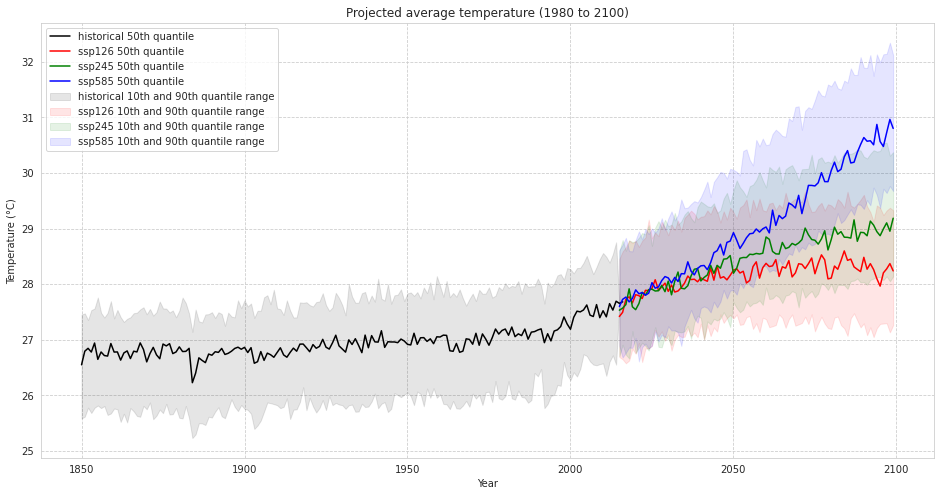

In [7]:
data_90 = data.quantile(0.9, dim='model')
data_10 = data.quantile(0.1, dim='model')
data_50 = data.quantile(0.5, dim='model')

fig, ax = plt.subplots(1, 1, figsize = (16, 8))

colours = ['black','red','green','blue']
for i in np.arange(len(experiments)):
    ax.plot(data_50.year, data_50[i,:], color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 50th quantile')
    ax.fill_between(data_50.year, data_90[i,:], data_10[i,:], alpha=0.1, color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 10th and 90th quantile range')

#ax.set_xlim(2100)
ax.set_title('Projected average temperature (1980 to 2100)')
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('Year')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

#fig.savefig(f'{DATADIR}CMIP6_annual_global_tas.png')

# Monthly temperature

In [30]:
monthly_temp = xr.open_mfdataset(glob(f'{DATADIR}/Aggregated/cmip6_tas_month_agg*T12:00:*.nc'))

monthly_temp.load()

<xarray.Dataset>
Dimensions:     (time: 1452, model: 3, experiment: 4)
Coordinates:
  * time        (time) datetime64[ns] 1980-01-16T12:00:00 ... 2100-12-16T12:0...
  * model       (model) object 'IPSL-CM6A-LR' 'MIROC-ES2L' 'MPI-ESM1-2-LR'
  * experiment  (experiment) object 'historical' 'ssp126' 'ssp245' 'ssp585'
    height      float64 2.0
Data variables:
    tas         (experiment, model, time) float64 26.23 26.27 ... 30.24 30.32

### Monthly timeseries

/tmp/ipykernel_31526/1796045539.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(('Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'), fontsize=16)


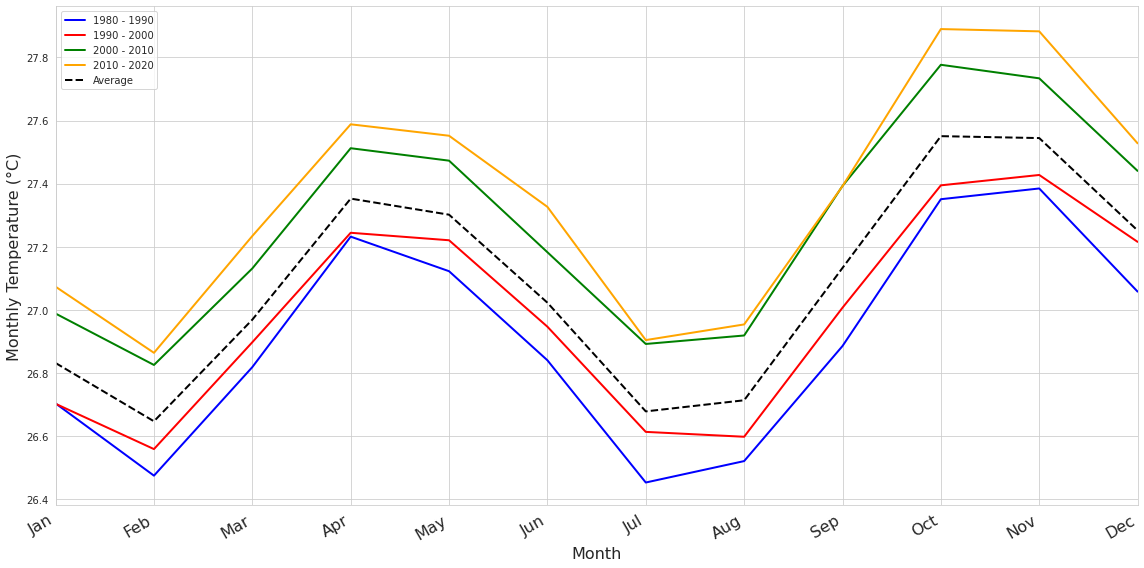

In [31]:
temp = monthly_temp.tas.mean(dim='model')

fig, ax = plt.subplots(1, 1 , figsize=(16,8))

temp[0].sel(time=slice("1980", "1990")).groupby('time.month').mean().plot(ax=ax, color='b', linewidth=2, label='1980 - 1990')
temp[0].sel(time=slice("1990", "2000")).groupby('time.month').mean().plot(ax=ax,  color='r', linewidth=2, label='1990 - 2000')
temp[0].sel(time=slice("2000", "2010")).groupby('time.month').mean().plot(ax=ax,  color='g', linewidth=2, label='2000 - 2010')
temp[0].sel(time=slice("2010", "2015")).groupby('time.month').mean().plot(ax=ax,  color='orange', linewidth=2, label='2010 - 2020')
temp[0].groupby('time.month').mean().plot(ax=ax,  color='black', linewidth=2, linestyle= 'dashed', label='Average')

ax.legend()
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Monthly Temperature (°C)', fontsize=16)

fig.autofmt_xdate()


plt.title('')
plt.xlim(1, 12)
plt.locator_params(axis='x', nbins=12)
ax.set_xticklabels(('Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'), fontsize=16)
plt.tight_layout()

#plt.savefig('Monthlytemp.png', dpi=300)

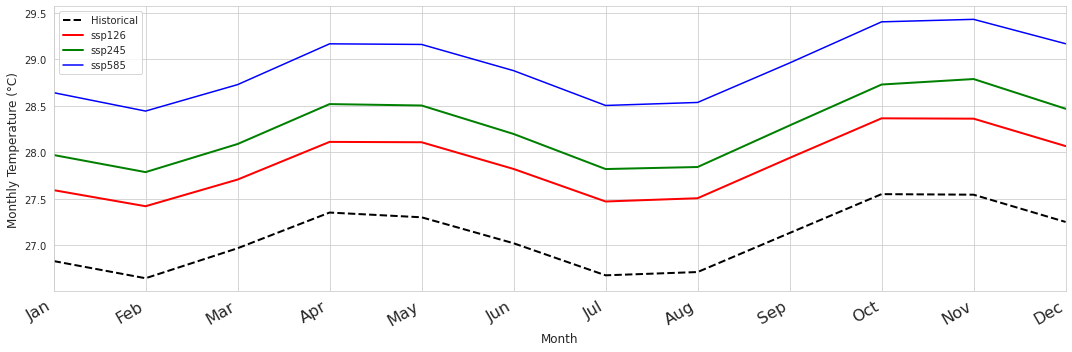

In [32]:
temp = monthly_temp.tas.mean(dim='model')
temp = temp.groupby('time.month').mean()

fig, ax = plt.subplots(1, 1 , figsize=(15,5))

ax.plot(temp[0],  color='black', linewidth=2, linestyle= 'dashed',label='Historical')
ax.plot(temp[1],  color='r', linewidth=2, label='ssp126')
ax.plot(temp[2],  color='g', linewidth=2, label='ssp245')
ax.plot(temp[3], color='b', label='ssp585')

ax.legend()
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Monthly Temperature (°C)', fontsize=12)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()

plt.xlim(0, 11)

#plt.locator_params(axis='x', nbins=12)

positions = [0, 1, 2, 3, 4, 5,6,7,8,9,10,11]

ax.xaxis.set_major_locator(ticker.FixedLocator(positions))

ax.set_xticklabels(('Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'), fontsize=16)

plt.tight_layout()

### Anomalies per month

In [37]:
temp = monthly_temp.tas.mean(dim='model')

month_temp = temp[0].resample(time='1M').mean()
month_clim = month_temp.mean()
month_anom = month_temp - month_clim

m_temp = month_anom.to_dataframe()
m_temp['positive'] = m_temp['tas'] > 0
m_temp['Rolling'] = m_temp['tas'].rolling(5).mean()
m_temp.reset_index(inplace=True)
m_temp['time'] = pd.to_datetime(m_temp['time'])

m_temp['year'] = m_temp['time'].dt.year

m_temp['month'] = m_temp['time'].dt.month_name()

m_temp = m_temp[['tas','year','month']]

m_temp_anom = m_temp.pivot_table(columns='year',index='month',values='tas')

m_temp_anom = m_temp_anom[[1980,1985,1990,
            1995,2000,2005,2010]]

m_temp_anom = m_temp_anom.reindex(([ 'January','February','March','April', 'May','June','July','August' ,'September','October', 'November','December']))

Text(0.5, 0, 'Month')

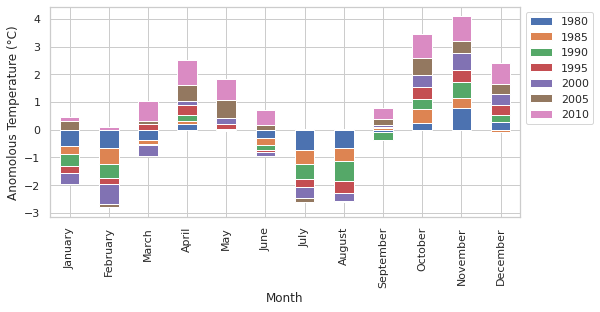

In [38]:
#set seaborn plotting aesthetics
plt.rcParams["figure.figsize"] = [8.5, 4.50]
plt.rcParams["figure.autolayout"] = True
sns.set(style='whitegrid')

#create stacked bar chart
m_temp_anom.plot(kind='bar', stacked=True)

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.ylabel('Anomolous Temperature (°C)')
plt.xlabel('Month')

### Future Anomalies

In [513]:
historical_mean = monthly_temp.tas.mean(dim='model')

In [514]:
temp_clim = historical_mean[0].mean()
temp_anom = historical_mean[0] - temp_clim

In [515]:
df = temp_anom.to_dataframe()
df = df.loc['1980':'2015']

In [516]:
df['positive'] = df['tas'] > 0
df['Rolling'] = df['tas'].rolling(5).mean()

In [517]:
df.reset_index(inplace=True)

In [518]:
df

,time,experiment,height,tas,positive,Rolling
0,1980-01-16 12:00:00,historical,2.0,-0.579018,False,NaN
1,1980-02-15 12:00:00,historical,2.0,-0.654763,False,NaN
2,1980-03-16 12:00:00,historical,2.0,-0.386157,False,NaN
3,1980-04-16 00:00:00,historical,2.0,0.188207,True,NaN
4,1980-05-16 12:00:00,historical,2.0,-0.002766,False,-0.286899
...,...,...,...,...,...,...
427,2015-08-16 12:00:00,historical,2.0,NaN,False,NaN
428,2015-09-16 00:00:00,historical,2.0,NaN,False,NaN
429,2015-10-16 12:00:00,historical,2.0,NaN,False,NaN
430,2015-11-16 00:00:00,historical,2.0,NaN,False,NaN


In [519]:
df['year'] = df.time.dt.year

In [520]:
def q1(x):
    return x.quantile(0.90)

def q2(x):
    return x.quantile(0.95)

def q3(x):
    return x.quantile(0.99)

In [521]:
monthly_anom = df.tas.groupby(df.year).agg([q1, q2, q3])

In [522]:
monthly_anom.reset_index(inplace=True)

In [523]:
monthly_anom.year = monthly_anom.year.astype('int32')

monthly_anom.year = pd.to_datetime(monthly_anom.year, format='%Y')

In [524]:
monthly_anom.set_index('year', inplace=True)

In [525]:
mean_monthly_anom = monthly_anom.resample('5Y').mean()

In [526]:
mean_monthly_anom.index = mean_monthly_anom.index.year

In [527]:
mean_monthly_anom

,q1,q2,q3
year,,,
1980,0.269401,0.501435,0.723889
1985,0.229283,0.287073,0.332447
1990,0.253277,0.305501,0.351536
1995,0.193108,0.256870,0.308515
2000,0.440125,0.481453,0.509525
2005,0.637577,0.725782,0.796864
2010,0.629875,0.674791,0.707814
2015,0.727758,0.814796,0.883104


Text(0, 0.5, 'Temperature anomaly (°C)')

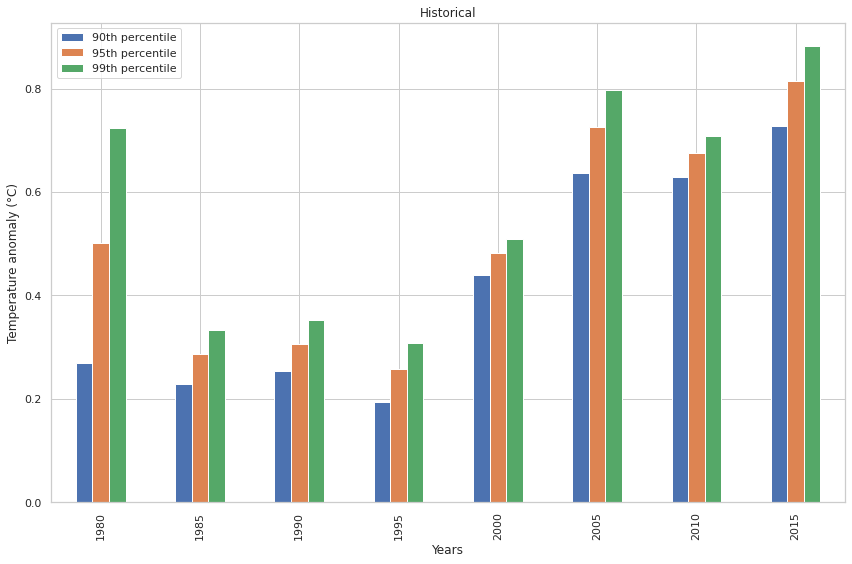

In [528]:
fig, ax = plt.subplots()

mean_monthly_anom.plot(kind='bar', ax=ax, title='Historical')

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

labels = ['90th percentile','95th percentile','99th percentile']

ax.legend(labels)
plt.xlabel('Years')
plt.ylabel('Temperature anomaly (°C)')

##### Future

In [529]:
temp  = monthly_temp.tas.mean(dim='model')
#precip[1].plot()

In [530]:
temp  = monthly_temp.tas.mean(dim='model')

temp_clim = temp[0].mean()
temp_anom = temp[1] - temp_clim

df = temp_anom.to_dataframe()
df = df.loc['2015':'2100']

df['positive'] = df['tas'] > 0
df['Rolling'] = df['tas'].rolling(5).mean()

df.reset_index(inplace=True)

df['year'] = df.time.dt.year

def q1(x):
    return x.quantile(0.90)

def q2(x):
    return x.quantile(0.95)

def q3(x):
    return x.quantile(0.99)

ssp126_anom = df.tas.groupby(df.year).agg([q1, q2, q3])

ssp126_anom.reset_index(inplace=True)

ssp126_anom.year = ssp126_anom.year.astype('int32')

ssp126_anom.year = pd.to_datetime(ssp126_anom.year, format='%Y')

ssp126_anom.set_index('year', inplace=True)

mean_ssp126_anom = ssp126_anom.resample('5Y').mean()

mean_ssp126_anom.index = mean_ssp126_anom.index.year

mean_ssp126_anom

,q1,q2,q3
year,,,
2015,0.807797,0.856575,0.894069
2020,0.790065,0.865820,0.926135
2025,0.907990,1.003479,1.083112
2030,1.035242,1.108133,1.164779
2035,1.080833,1.159292,1.221802
2040,1.199718,1.258251,1.305731
2045,1.297949,1.382983,1.448413
2050,1.385019,1.479066,1.560091
2055,1.296012,1.352761,1.399687


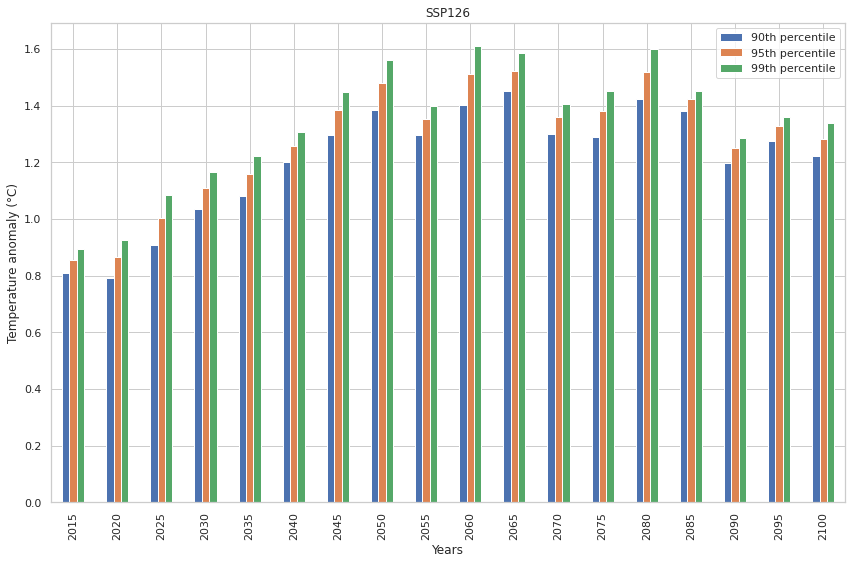

In [531]:
plt.rcParams["figure.figsize"] = [12, 8]
fig, ax = plt.subplots(1,1)

mean_ssp126_anom.plot(kind='bar', ax=ax, title='SSP126', legend=False)


#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


labels = ['90th percentile','95th percentile','99th percentile']

plt.legend()
plt.legend(bbox_to_anchor=(1.0, 1.0), labels=labels)
plt.xlabel('Years')
plt.ylabel('Temperature anomaly (°C)')
plt.tight_layout()

Text(0, 0.5, 'Temperature anomaly (°C)')

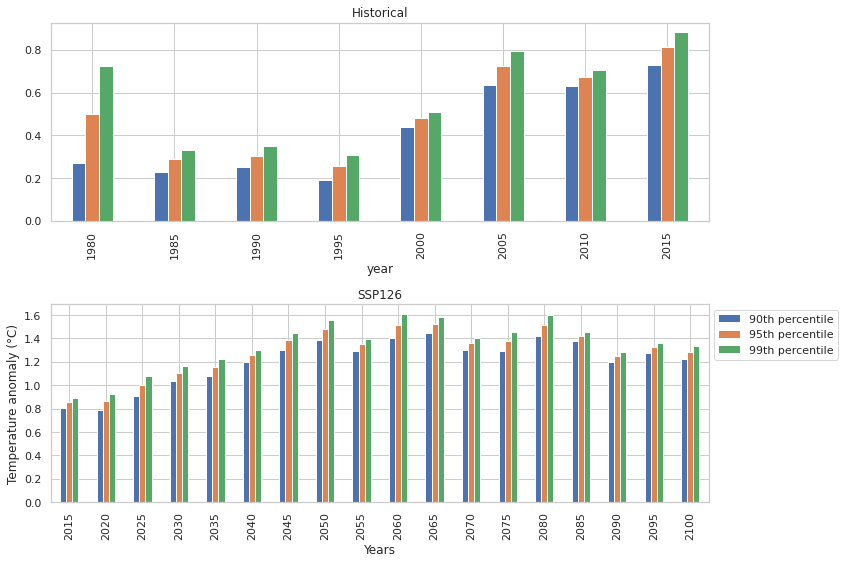

In [532]:
plt.rcParams["figure.figsize"] = [12, 8]
fig, ax = plt.subplots(2,1)


mean_monthly_anom.plot(kind='bar', ax=ax[0], title='Historical', legend=False)

mean_ssp126_anom.plot(kind='bar', ax=ax[1], title='SSP126', legend=False)


#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


labels = ['90th percentile','95th percentile','99th percentile']

plt.legend()
plt.legend(bbox_to_anchor=(1.0, 1.0), labels=labels)
plt.xlabel('Years')
plt.ylabel('Temperature anomaly (°C)')

In [533]:
df['positive'] = df['positive'].astype(str)

df['positive'] = df['positive'].str.replace('True','Positive')
df['positive'] = df['positive'].str.replace('False','Negative')

df.rename(columns={'positive':'Anomaly'}, inplace=True)

df.reset_index(inplace=True)

df['time'] = df.time.dt.year

df

,index,time,height,tas,Anomaly,Rolling,year
0,0,2015,2.0,0.221462,Positive,NaN,2015
1,1,2015,2.0,0.072736,Positive,NaN,2015
2,2,2015,2.0,0.356172,Positive,NaN,2015
3,3,2015,2.0,0.557465,Positive,NaN,2015
4,4,2015,2.0,0.818230,Positive,0.405213,2015
...,...,...,...,...,...,...,...
1027,1027,2100,2.0,0.300502,Positive,0.639550,2100
1028,1028,2100,2.0,1.009520,Positive,0.640958,2100
1029,1029,2100,2.0,1.420319,Positive,0.723361,2100
1030,1030,2100,2.0,1.415589,Positive,0.901645,2100


In [534]:
temp_clim1 = historical_mean[0].mean()
temp_anom1 = historical_mean[0] - temp_clim1

df1 = temp_anom1.to_dataframe()
df1 = df1.loc['1980':'2015']

df1['positive'] = df1['tas'] > 0

df1['positive'] = df1['positive'].astype(str)

df1['positive'] = df1['positive'].str.replace('True','Positive')
df1['positive'] = df1['positive'].str.replace('False','Negative')

df1.rename(columns={'positive':'Anomaly'}, inplace=True)

df1.reset_index(inplace=True)

df1['time'] = df1.time.dt.year

df1

,time,experiment,height,tas,Anomaly
0,1980,historical,2.0,-0.579018,Negative
1,1980,historical,2.0,-0.654763,Negative
2,1980,historical,2.0,-0.386157,Negative
3,1980,historical,2.0,0.188207,Positive
4,1980,historical,2.0,-0.002766,Negative
...,...,...,...,...,...
427,2015,historical,2.0,NaN,Negative
428,2015,historical,2.0,NaN,Negative
429,2015,historical,2.0,NaN,Negative
430,2015,historical,2.0,NaN,Negative


In [535]:
from altair_saver import save
#df.reset_index(inplace=True)

bar1 = alt.Chart(df1).mark_bar().encode(
    x="time:O",
    y="tas:Q",
    color='Anomaly:N').properties(width=600).encode(x=alt.X('time:O', axis=alt.Axis(title='Year',titleFontSize=15, labelFontSize=12)),
                              y=alt.Y('pr:Q', axis=alt.Axis(title='Temperature Anomaly ', titleFontSize=15, labelFontSize=12)))

bar2 = alt.Chart(df1).mark_bar().encode(
    x="time:O",
    y="tas:Q",
    color='Anomaly:N')

bar1 + bar2
#(bar+bar2).properties(width=100, height=400)

alt.LayerChart(...)

### Distribution

In [536]:
temp  = monthly_temp.tas.mean(dim='model')

temp_clim = temp[0].mean()
temp_anom = temp[1] - temp_clim

df = temp_anom.to_dataframe()
df = df.loc['2010':'2100']

df.reset_index(inplace=True)

df['year'] = df.time.dt.year

ssp126_anom = df

ssp126_anom.reset_index(inplace=True)

ssp126_anom.year = ssp126_anom.year.astype('int32')

ssp126_anom.year = pd.to_datetime(ssp126_anom.year, format='%Y')

ssp126_anom.set_index('year', inplace=True)

mean_ssp126_anom = ssp126_anom.resample('1Y').mean()

mean_ssp126_anom = mean_ssp126_anom.resample('10Y').mean()

mean_ssp126_anom.index = mean_ssp126_anom.index.year

mean_ssp126_anom.drop(columns={'index','height'}, inplace=True)

mean_ssp126_anom.rename(columns={'tas':'ssp126'}, inplace=True)


In [537]:
temp  = monthly_temp.tas.mean(dim='model')

temp_clim = temp[0].mean()
temp_anom = temp[2] - temp_clim

df = temp_anom.to_dataframe()
df = df.loc['2010':'2100']

df.reset_index(inplace=True)

df['year'] = df.time.dt.year

ssp245_anom = df

ssp245_anom.reset_index(inplace=True)

ssp245_anom.year = ssp245_anom.year.astype('int32')

ssp245_anom.year = pd.to_datetime(ssp245_anom.year, format='%Y')

ssp245_anom.set_index('year', inplace=True)

mean_ssp245_anom = ssp245_anom.resample('1Y').mean()

mean_ssp245_anom = mean_ssp245_anom.resample('10Y').mean()

mean_ssp245_anom.index = mean_ssp245_anom.index.year

mean_ssp245_anom.drop(columns={'index','height'}, inplace=True)

mean_ssp245_anom.rename(columns={'tas':'ssp245'}, inplace=True)

In [538]:
temp  = monthly_temp.tas.mean(dim='model')

temp_clim = temp[0].mean()
temp_anom = temp[3] - temp_clim

df = temp_anom.to_dataframe()
df = df.loc['2010':'2100']

df.reset_index(inplace=True)

df['year'] = df.time.dt.year

ssp585_anom = df

ssp585_anom.reset_index(inplace=True)

ssp585_anom.year = ssp585_anom.year.astype('int32')

ssp585_anom.year = pd.to_datetime(ssp585_anom.year, format='%Y')

ssp585_anom.set_index('year', inplace=True)

mean_ssp585_anom = ssp585_anom.resample('1Y').mean()

mean_ssp585_anom = mean_ssp585_anom.resample('10Y').mean()

mean_ssp585_anom.index = mean_ssp585_anom.index.year

mean_ssp585_anom.drop(columns={'index','height'}, inplace=True)

mean_ssp585_anom.rename(columns={'tas':'ssp585'}, inplace=True)


In [539]:
decade_trend_temp = pd.concat([mean_ssp126_anom,mean_ssp245_anom,mean_ssp585_anom], axis=1)
decade_trend_temp = decade_trend_temp[1:]

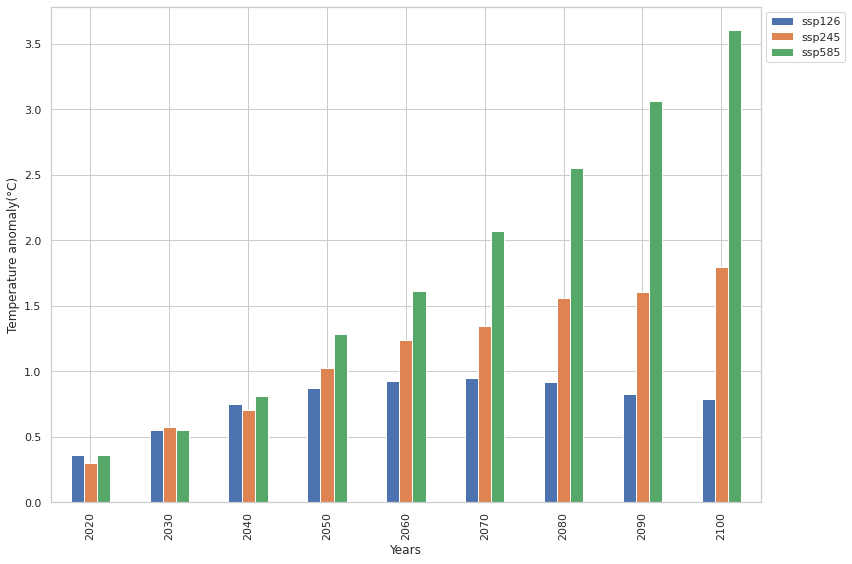

In [540]:
plt.rcParams["figure.figsize"] = [12, 8]
fig, ax = plt.subplots(1,1)

decade_trend_temp.plot(kind='bar', ax=ax)


#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


#labels = ['90th percentile','95th percentile','99th percentile']

plt.legend()
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Years')
plt.ylabel('Temperature anomaly(°C)')
plt.tight_layout()

In [541]:
temp = monthly_temp.tas.mean(dim='model')

test = temp.to_dataframe()

test.reset_index(inplace=True)

test.set_index('time', inplace=True)

test = test.groupby('experiment').resample('1Y').mean()

test.reset_index(inplace=True)

test

,experiment,time,height,tas
0,historical,1980-12-31,2.0,26.922392
1,historical,1981-12-31,2.0,27.037736
2,historical,1982-12-31,2.0,26.748020
3,historical,1983-12-31,2.0,26.664918
4,historical,1984-12-31,2.0,26.889105
...,...,...,...,...
479,ssp585,2096-12-31,2.0,30.960040
480,ssp585,2097-12-31,2.0,30.741119
481,ssp585,2098-12-31,2.0,30.773207
482,ssp585,2099-12-31,2.0,30.855929


Text(0.5, 0, 'Temperature (°C)')

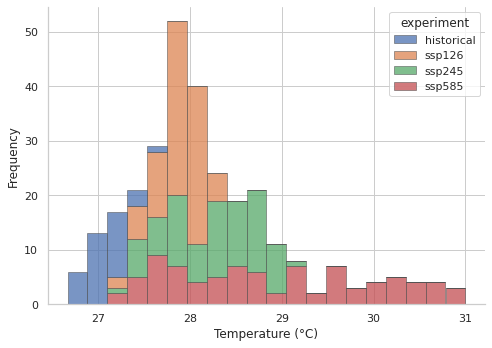

In [542]:
f, ax = plt.subplots(figsize=(7, 5))

# removes the top and right axes spines
sns.despine(f)

# plot according to classification
sns.histplot(
    test,
    x="tas", hue="experiment",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    bins=20
)

plt.ylabel('Frequency')
plt.xlabel('Temperature (°C)')
#ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_xticks([500, 1000, 2000, 5000, 10000])

Text(0.5, 0, 'Temperature (°C)')

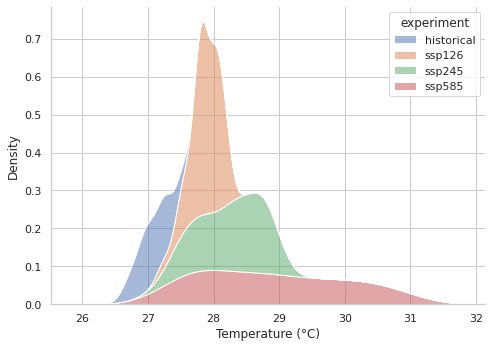

In [543]:
f, ax = plt.subplots(figsize=(7, 5))

# removes the top and right axes spines
sns.despine(f)

# plot according to classification
sns.kdeplot(
    data=test,
    x="tas", hue="experiment",multiple="stack",
    fill=True, common_norm=True,
    alpha=.5
)

plt.xlabel('Temperature (°C)')

### Distribution grouped

In [544]:
temp  = monthly_temp.tas.mean(dim='model')

temp_clim = temp[0].mean()
temp_anom = temp[1] - temp_clim

df = temp_anom.to_dataframe()
df = df.loc['2010':'2100']

df.reset_index(inplace=True)

df['year'] = df.time.dt.year

ssp126_anom = df

ssp126_anom.reset_index(inplace=True)

ssp126_anom.year = ssp126_anom.year.astype('int32')

ssp126_anom.year = pd.to_datetime(ssp126_anom.year, format='%Y')

ssp126_anom.set_index('year', inplace=True)

mean_ssp126_anom = ssp126_anom.resample('1Y').mean()

#mean_ssp126_anom = mean_ssp126_anom.resample('10Y').mean()

mean_ssp126_anom.index = mean_ssp126_anom.index.year

mean_ssp126_anom.drop(columns={'index','height'}, inplace=True)

mean_ssp126_anom.rename(columns={'tas':'ssp126'}, inplace=True)

temp  = monthly_temp.tas.mean(dim='model')

temp_clim = temp[0].mean()
temp_anom = temp[2] - temp_clim

df = temp_anom.to_dataframe()
df = df.loc['2010':'2100']

df.reset_index(inplace=True)

df['year'] = df.time.dt.year

ssp245_anom = df

ssp245_anom.reset_index(inplace=True)

ssp245_anom.year = ssp245_anom.year.astype('int32')

ssp245_anom.year = pd.to_datetime(ssp245_anom.year, format='%Y')

ssp245_anom.set_index('year', inplace=True)

mean_ssp245_anom = ssp245_anom.resample('1Y').mean()

#mean_ssp245_anom = mean_ssp245_anom.resample('10Y').mean()

mean_ssp245_anom.index = mean_ssp245_anom.index.year

mean_ssp245_anom.drop(columns={'index','height'}, inplace=True)

mean_ssp245_anom.rename(columns={'tas':'ssp245'}, inplace=True)

temp  = monthly_temp.tas.mean(dim='model')

temp_clim = temp[0].mean()
temp_anom = temp[3] - temp_clim

df = temp_anom.to_dataframe()
df = df.loc['2010':'2100']

df.reset_index(inplace=True)

df['year'] = df.time.dt.year

ssp585_anom = df

ssp585_anom.reset_index(inplace=True)

ssp585_anom.year = ssp585_anom.year.astype('int32')

ssp585_anom.year = pd.to_datetime(ssp585_anom.year, format='%Y')

ssp585_anom.set_index('year', inplace=True)

mean_ssp585_anom = ssp585_anom.resample('1Y').mean()

#mean_ssp585_anom = mean_ssp585_anom.resample('10Y').mean()

mean_ssp585_anom.index = mean_ssp585_anom.index.year

mean_ssp585_anom.drop(columns={'index','height'}, inplace=True)

mean_ssp585_anom.rename(columns={'tas':'ssp585'}, inplace=True)

decade_trend_temp = pd.concat([mean_ssp126_anom,mean_ssp245_anom,mean_ssp585_anom], axis=1)
decade_trend_temp = decade_trend_temp[1:]

decade_trend_temp

decade_stack = decade_trend_temp.transpose()

stack_anom = decade_stack.stack()

stack_anom = stack_anom.to_frame()

stack_anom.reset_index(inplace=True)

stack_anom.rename(columns={'level_0':'experiment',0:'tas'}, inplace=True)

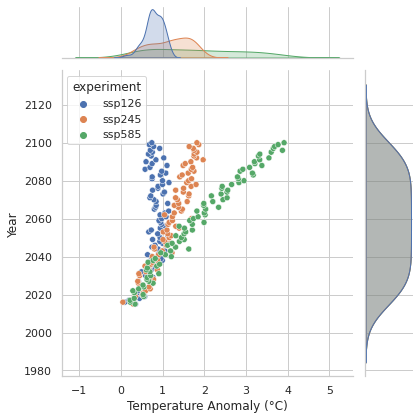

In [545]:
ax = sns.jointplot(x = "tas", y = "year", data = stack_anom, hue='experiment')
ax.set_axis_labels(xlabel='Temperature Anomaly (°C)', ylabel='Year')